# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('emu_tree', {'root_raw/em18_raw/ggH_bbtt*.root', 'root_raw/em18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('emu_tree', 'root_raw/em17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('emu_tree',  {'root_raw/em17_raw/ggH_bbtt*.root', 'root_raw/em17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('emu_tree', 'root_raw/em17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('emu_tree', 'root_raw/em17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('emu_tree', 'root_raw/em16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('emu_tree', {'root_raw/em16_raw/ggH_bbtt*.root', 'root_raw/em16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('emu_tree', 'root_raw/em16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('emu_tree', 'root_raw/em16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 1b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4184 && bpt_deepcsv_2<0')
    files17[i] = files17[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4941 && bpt_deepcsv_2<0')
    files16[i] = files16[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.6321 && bpt_deepcsv_2<0')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
myele = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((myele+mymu+mymet).Pt(),(myele+mymu+mymet).Eta(),(myele+mymu+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
m_btt = '(mytt+myb1).M()'
m_b1ele = '(myele+myb1).M()'
m_b1mu = '(mymu+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(myele,mymu)'
dR_b1ele = 'ROOT::Math::VectorUtil::DeltaR(myele,myb1)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'

# define transverse masses mT and D_zeta
mT_ele = 'sqrt(pow(myele.Pt()+mymet.Pt(),2)-pow(myele.Px()+mymet.Px(),2)-pow(myele.Py()+mymet.Py(),2))'
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(myele.Px()/myele.Pt()+mymu.Px()/mymu.Pt(),2)+pow(myele.Py()/myele.Pt()+mymu.Py()/mymu.Pt(),2))'
x_zeta = '(myele.Px()/myele.Pt()+mymu.Px()/mymu.Pt())/norm_zeta'
y_zeta = '(myele.Py()/myele.Pt()+mymu.Py()/mymu.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(myele.Px()+mymu.Px())*x_zeta+(myele.Py()+mymu.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files17[i] = files17[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files16[i] = files16[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 ele+mu trigger requirements
trigger823_18 = '(passMu8E23DZ && matchMu8E23DZ_1 && filterMu8E23DZ_1 && matchMu8E23DZ_2 && filterMu8E23DZ_2 && pt_1>24 && pt_2>13)'
trigger2312_18 = '(passMu23E12DZ && matchMu23E12DZ_1 && filterMu23E12DZ_1 && matchMu23E12DZ_2 && filterMu23E12DZ_2 && pt_1>13 && pt_2>24)'

trigger_all_18 = trigger823_18 + str(' or ') + trigger2312_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('fabs(eta_1)<2.4 && fabs(eta_2)<2.4')\
    .Filter('dR_tt>0.3')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('!(gen_match_1>2 && gen_match_1<6 && gen_match_2>2 && gen_match_2<6)')

files18[1] = files18[1].Filter('gen_match_1==3 && gen_match_2==4')#recontructed taus are gen taus
files18[1] = files18[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

# triggers
files18[0] = files18[0].Filter(trigger_all_18).Filter('iso_1<0.3 && iso_2<0.3')
files18[1] = files18[1].Filter(trigger_all_18).Filter('iso_1<0.15 && iso_2<0.15')
files18[2] = files18[2].Filter(trigger_all_18).Filter('iso_1<0.15 && iso_2<0.15')
files18[3] = files18[3].Filter(trigger_all_18).Filter('iso_1<0.15 && iso_2<0.15')

# QCD region
qcd_18 = files18[0].Filter('q_1*q_2>0').Filter('gen_match_1<6 && gen_match_2<6')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')

######################## 2 0 1 7 ##########################
# 2017 ele+mu trigger requirements 
trigger823_17 = '(passMu8E23DZ && matchMu8E23DZ_1 && filterMu8E23DZ_1 && matchMu8E23DZ_2 && filterMu8E23DZ_2 && pt_1>24 && pt_2>13)'
trigger2312_17 = '(passMu23E12DZ && matchMu23E12DZ_1 && filterMu23E12DZ_1 && matchMu23E12DZ_2 && filterMu23E12DZ_2 && pt_1>13 && pt_2>24)'

trigger_all_17 = trigger823_17 + str(' or ') + trigger2312_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('fabs(eta_1)<2.4 && fabs(eta_2)<2.4')\
    .Filter('dR_tt>0.3')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('!(gen_match_1>2 && gen_match_1<6 && gen_match_2>2 && gen_match_2<6)')

files17[1] = files17[1].Filter('gen_match_1==3 && gen_match_2==4')#recontructed taus are gen taus
files17[1] = files17[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

# triggers
files17[0] = files17[0].Filter(trigger_all_17).Filter('iso_1<0.3 && iso_2<0.3')
files17[1] = files17[1].Filter(trigger_all_17).Filter('iso_1<0.15 && iso_2<0.15')
files17[2] = files17[2].Filter(trigger_all_17).Filter('iso_1<0.15 && iso_2<0.15')
files17[3] = files17[3].Filter(trigger_all_17).Filter('iso_1<0.15 && iso_2<0.15')

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('gen_match_1<6 && gen_match_2<6')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')

######################## 2 0 1 6 ##########################
# 2016 ele+mu trigger requirements
trigger823_16 = '(passMu8E23 && matchMu8E23_1 && filterMu8E23_1 && matchMu8E23_2 && pt_1>24 && pt_2>13)'
trigger2312_16 = '(passMu23E12 && matchMu23E12_1 && filterMu23E12_1 && matchMu23E12_2 && pt_1>13 && pt_2>24)'

trigger_all_16 = trigger823_16 + str(' or ') + trigger2312_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('fabs(eta_1)<2.4 && fabs(eta_2)<2.4')\
    .Filter('dR_tt>0.3')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('!(gen_match_1>2 && gen_match_1<6 && gen_match_2>2 && gen_match_2<6)')

files16[1] = files16[1].Filter('gen_match_1==3 && gen_match_2==4')#recontructed taus are gen taus
files16[1] = files16[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16).Filter('iso_1<0.3 && iso_2<0.3')
files16[1] = files16[1].Filter(trigger_all_16).Filter('iso_1<0.15 && iso_2<0.15')
files16[2] = files16[2].Filter(trigger_all_16).Filter('iso_1<0.15 && iso_2<0.15')
files16[3] = files16[3].Filter(trigger_all_16).Filter('iso_1<0.15 && iso_2<0.15')

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('gen_match_1<6 && gen_match_2<6')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 1b events
feature_list = ['pt_1', 'pt_2', 'm_btt', 'm_b1ele', 'm_b1mu',\
                'dR_tt', 'dR_b1ele', 'dR_b1mu', 'dR_b1tt',\
                'tt_eta', 'mT_ele', 'mT_mu', 'mT_b1', 'Dzeta',\
                'bpt_deepcsv_1']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd_18 = pd.DataFrame(qcd_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18.shape: ' + str(qcd_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (12718, 15)
ZTT18.shape  : (233024, 15)
TT18.shape   : (2109616, 15)
qcd18.shape: (20985, 15)

sig17.shape  : (12342, 15)
ZTT17.shape  : (172185, 15)
TT17.shape   : (274564, 15)
qcd17.shape  : (13216, 15)

sig16.shape  : (13511, 15)
ZTT16.shape  : (90505, 15)
TT16.shape   : (187861, 15)
qcd16.shape  : (5259, 15)

sig_allyears.shape: (38571, 16)
ZTT_allyears.shape: (495714, 16)
TT_allyears.shape : (2572041, 16)
qcd_allyears.shape: (39460, 16)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 1196, random_state = 20)#7153->3.1%->
TT_allyears = TT_allyears.sample(n = 35678, random_state = 20)#216569->92.5%->
qcd_allyears = qcd_allyears.sample(n = 1697, random_state = 20)#10363->4.4%->

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
            pt_1       pt_2       m_btt     m_b1ele      m_b1mu     dR_tt  \
0      32.766426  15.704816   87.354745   70.919945   49.357836  0.349437   
1      25.052036  17.893099   92.935893   69.188936   58.480897  0.332860   
2      15.301179  36.634205  108.660589   54.412048   78.771821  0.359545   
3      26.271544  15.743111   75.728072   78.679200   64.079880  0.333675   
4      32.425983  14.820876   43.810212   79.316565   55.644968  0.391901   
...          ...        ...         ...         ...         ...       ...   
7201   94.336082  60.255882  333.731025  130.150377  166.436327  2.587731   
8428   13.935691  31.375950  113.338252   78.056477   84.192281  0.780583   
1600   57.647976  20.539001  198.145540  129.415450   24.485988  3.039610   
18099  35.098938  28.454430  180.285785   79.877436   36.020521  3.105321   
2538   36.332829  24.400978  314.901403  115.241729   88.301061  1.819483   

       dR_b1ele   dR_b1mu   dR_b1tt    tt_eta      mT_ele  

## Compare input feature distributions between sig and bkg

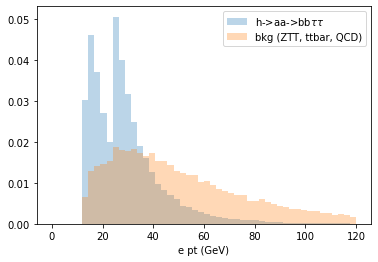

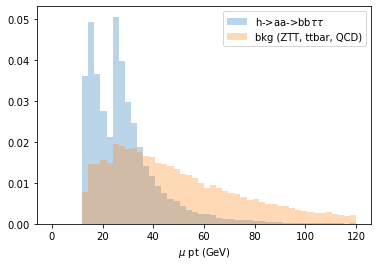

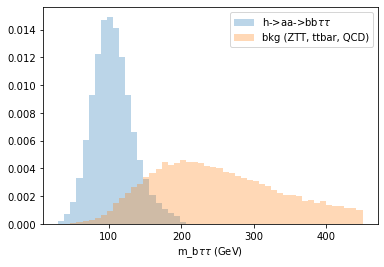

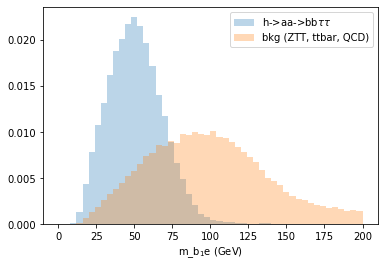

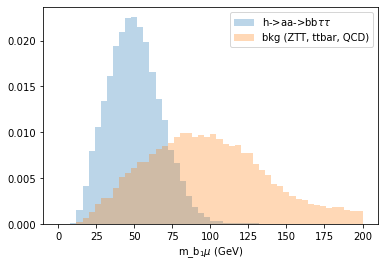

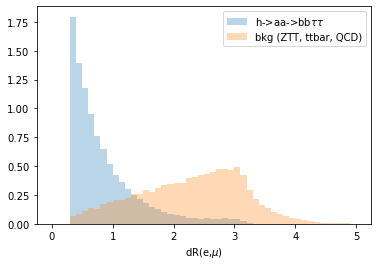

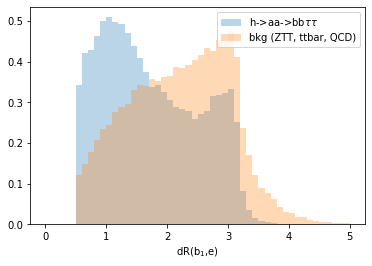

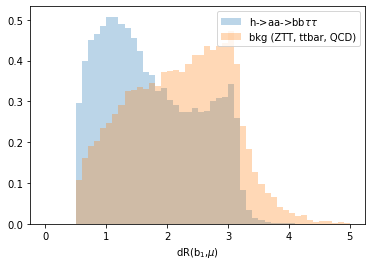

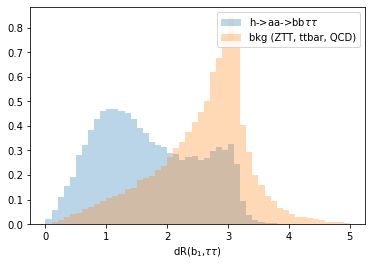

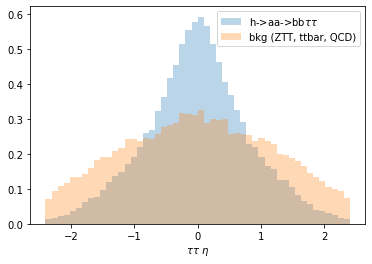

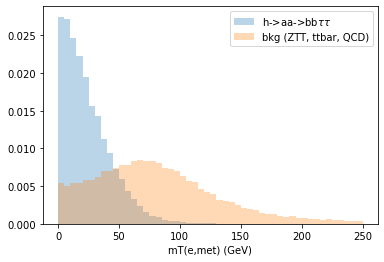

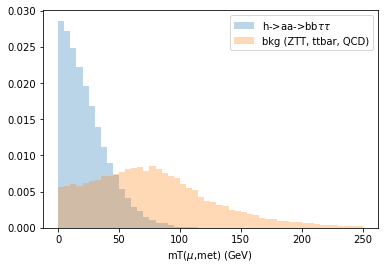

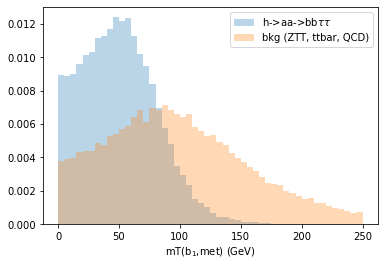

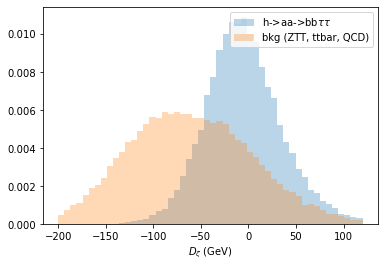

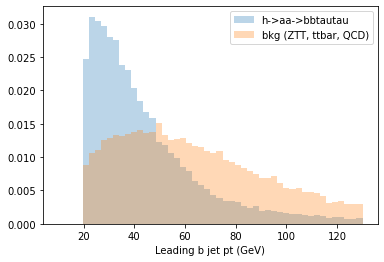

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('e pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$e (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(e,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()

pyplot.hist(sig_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(e,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()


## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (46284, 15)
Y_train.shape: (46284, 1)
X_val.shape: (15429, 15)
Y_val.shape: (15429, 1)
X_test.shape: (15429, 15)
Y_test.shape: (15429, 1)

Total number of sig/bkg examples: 38571/38571 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 23199/23085 (50.1%/49.9%)
val   : 7645/7784 (49.5%/50.5%)
test  : 7727/7702 (50.1%/49.9%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 25,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 2, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-04-13 18:03:20.569159: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-04-13 18:03:20.570475: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 25, validation_data = (X_val,Y_val), batch_size = 256)

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 2:19 - loss: 0.7691 - accuracy: 0.51 - ETA: 15s - loss: 0.7218 - accuracy: 0.5673 - ETA: 8s - loss: 0.6606 - accuracy: 0.636 - ETA: 6s - loss: 0.6146 - accuracy: 0.69 - ETA: 4s - loss: 0.5757 - accuracy: 0.72 - ETA: 3s - loss: 0.5362 - accuracy: 0.76 - ETA: 3s - loss: 0.4999 - accuracy: 0.78 - ETA: 2s - loss: 0.4683 - accuracy: 0.80 - ETA: 2s - loss: 0.4404 - accuracy: 0.82 - ETA: 1s - loss: 0.4169 - accuracy: 0.83 - ETA: 1s - loss: 0.3954 - accuracy: 0.84 - ETA: 1s - loss: 0.3759 - accuracy: 0.85 - ETA: 1s - loss: 0.3617 - accuracy: 0.85 - ETA: 1s - loss: 0.3462 - accuracy: 0.86 - ETA: 0s - loss: 0.3342 - accuracy: 0.86 - ETA: 0s - loss: 0.3226 - accuracy: 0.87 - ETA: 0s - loss: 0.3126 - accuracy: 0.87 - ETA: 0s - loss: 0.3021 - accuracy: 0.88 - ETA: 0s - loss: 0.2925 - accuracy: 0.88 - ETA: 0s - loss: 0.2832 - accuracy: 0.89 - ETA: 0s - loss: 0.2755 - accuracy: 0.89 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:32 - loss: 0.8831 - accuracy: 0.39 - ETA: 8s - loss: 0.8620 - accuracy: 0.4425 - ETA: 4s - loss: 0.7978 - accuracy: 0.49 - ETA: 3s - loss: 0.7507 - accuracy: 0.53 - ETA: 2s - loss: 0.7102 - accuracy: 0.57 - ETA: 2s - loss: 0.6704 - accuracy: 0.61 - ETA: 1s - loss: 0.6318 - accuracy: 0.65 - ETA: 1s - loss: 0.5968 - accuracy: 0.68 - ETA: 1s - loss: 0.5683 - accuracy: 0.70 - ETA: 1s - loss: 0.5407 - accuracy: 0.72 - ETA: 0s - loss: 0.5169 - accuracy: 0.74 - ETA: 0s - loss: 0.5095 - accuracy: 0.74 - ETA: 0s - loss: 0.4873 - accuracy: 0.76 - ETA: 0s - loss: 0.4686 - accuracy: 0.77 - ETA: 0s - loss: 0.4504 - accuracy: 0.78 - ETA: 0s - loss: 0.4340 - accuracy: 0.79 - ETA: 0s - loss: 0.4180 - accuracy: 0.80 - ETA: 0s - loss: 0.4031 - accuracy: 0.81 - ETA: 0s - loss: 0.3904 - accuracy: 0.82 - ETA: 0s - loss: 0.3788 - accuracy: 0.82 - 2s 40us/sample - loss: 0.3767 - accuracy: 0.8292 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6922 - accuracy: 0.52 - ETA: 10s - loss: 0.6284 - accuracy: 0.6220 - ETA: 5s - loss: 0.5801 - accuracy: 0.683 - ETA: 4s - loss: 0.5312 - accuracy: 0.73 - ETA: 3s - loss: 0.4942 - accuracy: 0.77 - ETA: 2s - loss: 0.4621 - accuracy: 0.79 - ETA: 2s - loss: 0.4357 - accuracy: 0.81 - ETA: 1s - loss: 0.4103 - accuracy: 0.83 - ETA: 1s - loss: 0.3897 - accuracy: 0.84 - ETA: 1s - loss: 0.3721 - accuracy: 0.85 - ETA: 1s - loss: 0.3574 - accuracy: 0.85 - ETA: 1s - loss: 0.3451 - accuracy: 0.86 - ETA: 1s - loss: 0.3336 - accuracy: 0.87 - ETA: 0s - loss: 0.3231 - accuracy: 0.87 - ETA: 0s - loss: 0.3135 - accuracy: 0.87 - ETA: 0s - loss: 0.3056 - accuracy: 0.88 - ETA: 0s - loss: 0.2984 - accuracy: 0.88 - ETA: 0s - loss: 0.2903 - accuracy: 0.88 - ETA: 0s - loss: 0.2837 - accuracy: 0.89 - ETA: 0s - loss: 0.2755 - accuracy: 0.89 - ETA: 0s - loss: 0.2691 - accuracy: 0.89 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:30 - loss: 0.7772 - accuracy: 0.51 - ETA: 11s - loss: 0.6939 - accuracy: 0.5767 - ETA: 6s - loss: 0.6306 - accuracy: 0.653 - ETA: 4s - loss: 0.5761 - accuracy: 0.71 - ETA: 3s - loss: 0.5310 - accuracy: 0.75 - ETA: 2s - loss: 0.4948 - accuracy: 0.77 - ETA: 2s - loss: 0.4643 - accuracy: 0.79 - ETA: 2s - loss: 0.4353 - accuracy: 0.81 - ETA: 1s - loss: 0.4092 - accuracy: 0.83 - ETA: 1s - loss: 0.3845 - accuracy: 0.84 - ETA: 1s - loss: 0.3650 - accuracy: 0.85 - ETA: 1s - loss: 0.3479 - accuracy: 0.86 - ETA: 1s - loss: 0.3337 - accuracy: 0.86 - ETA: 1s - loss: 0.3212 - accuracy: 0.87 - ETA: 0s - loss: 0.3091 - accuracy: 0.87 - ETA: 0s - loss: 0.2971 - accuracy: 0.88 - ETA: 0s - loss: 0.2877 - accuracy: 0.88 - ETA: 0s - loss: 0.2791 - accuracy: 0.89 - ETA: 0s - loss: 0.2722 - accuracy: 0.89 - ETA: 0s - loss: 0.2638 - accuracy: 0.89 - ETA: 0s - loss: 0.2578 - accuracy: 0.89 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:30 - loss: 0.9685 - accuracy: 0.42 - ETA: 10s - loss: 0.8137 - accuracy: 0.5582 - ETA: 5s - loss: 0.7328 - accuracy: 0.602 - ETA: 3s - loss: 0.6614 - accuracy: 0.64 - ETA: 2s - loss: 0.6051 - accuracy: 0.69 - ETA: 2s - loss: 0.5619 - accuracy: 0.72 - ETA: 2s - loss: 0.5252 - accuracy: 0.75 - ETA: 1s - loss: 0.4918 - accuracy: 0.77 - ETA: 1s - loss: 0.4633 - accuracy: 0.78 - ETA: 1s - loss: 0.4390 - accuracy: 0.80 - ETA: 1s - loss: 0.4161 - accuracy: 0.81 - ETA: 1s - loss: 0.3974 - accuracy: 0.82 - ETA: 0s - loss: 0.3787 - accuracy: 0.83 - ETA: 0s - loss: 0.3622 - accuracy: 0.84 - ETA: 0s - loss: 0.3474 - accuracy: 0.85 - ETA: 0s - loss: 0.3338 - accuracy: 0.85 - ETA: 0s - loss: 0.3216 - accuracy: 0.86 - ETA: 0s - loss: 0.3103 - accuracy: 0.87 - ETA: 0s - loss: 0.3017 - accuracy: 0.87 - ETA: 0s - loss: 0.2934 - accuracy: 0.87 - ETA: 0s - loss: 0.2848 - accuracy: 0.88 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7393 - accuracy: 0.49 - ETA: 9s - loss: 0.6414 - accuracy: 0.6039 - ETA: 5s - loss: 0.5760 - accuracy: 0.69 - ETA: 3s - loss: 0.5212 - accuracy: 0.75 - ETA: 2s - loss: 0.4852 - accuracy: 0.78 - ETA: 2s - loss: 0.4484 - accuracy: 0.80 - ETA: 1s - loss: 0.4177 - accuracy: 0.82 - ETA: 1s - loss: 0.3904 - accuracy: 0.84 - ETA: 1s - loss: 0.3679 - accuracy: 0.85 - ETA: 1s - loss: 0.3491 - accuracy: 0.86 - ETA: 1s - loss: 0.3320 - accuracy: 0.87 - ETA: 0s - loss: 0.3185 - accuracy: 0.88 - ETA: 0s - loss: 0.3052 - accuracy: 0.88 - ETA: 0s - loss: 0.2935 - accuracy: 0.89 - ETA: 0s - loss: 0.2831 - accuracy: 0.89 - ETA: 0s - loss: 0.2726 - accuracy: 0.89 - ETA: 0s - loss: 0.2650 - accuracy: 0.90 - ETA: 0s - loss: 0.2574 - accuracy: 0.90 - ETA: 0s - loss: 0.2500 - accuracy: 0.90 - ETA: 0s - loss: 0.2426 - accuracy: 0.91 - ETA: 0s - loss: 0.2364 - accuracy: 0.91 - 2s 40us

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:37 - loss: 0.7203 - accuracy: 0.51 - ETA: 11s - loss: 0.7224 - accuracy: 0.5109 - ETA: 6s - loss: 0.6741 - accuracy: 0.543 - ETA: 4s - loss: 0.6286 - accuracy: 0.59 - ETA: 3s - loss: 0.5905 - accuracy: 0.64 - ETA: 2s - loss: 0.5573 - accuracy: 0.68 - ETA: 2s - loss: 0.5216 - accuracy: 0.71 - ETA: 1s - loss: 0.4899 - accuracy: 0.74 - ETA: 1s - loss: 0.4631 - accuracy: 0.76 - ETA: 1s - loss: 0.4350 - accuracy: 0.78 - ETA: 1s - loss: 0.4142 - accuracy: 0.80 - ETA: 1s - loss: 0.3934 - accuracy: 0.81 - ETA: 0s - loss: 0.3749 - accuracy: 0.82 - ETA: 0s - loss: 0.3606 - accuracy: 0.83 - ETA: 0s - loss: 0.3478 - accuracy: 0.84 - ETA: 0s - loss: 0.3340 - accuracy: 0.84 - ETA: 0s - loss: 0.3219 - accuracy: 0.85 - ETA: 0s - loss: 0.3116 - accuracy: 0.86 - ETA: 0s - loss: 0.3016 - accuracy: 0.86 - ETA: 0s - loss: 0.2929 - accuracy: 0.87 - ETA: 0s - loss: 0.2850 - accuracy: 0.87 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:34 - loss: 0.7448 - accuracy: 0.44 - ETA: 9s - loss: 0.6593 - accuracy: 0.5738 - ETA: 5s - loss: 0.6019 - accuracy: 0.66 - ETA: 4s - loss: 0.5546 - accuracy: 0.71 - ETA: 3s - loss: 0.5136 - accuracy: 0.75 - ETA: 2s - loss: 0.4789 - accuracy: 0.78 - ETA: 2s - loss: 0.4467 - accuracy: 0.80 - ETA: 1s - loss: 0.4188 - accuracy: 0.81 - ETA: 1s - loss: 0.3942 - accuracy: 0.83 - ETA: 1s - loss: 0.3711 - accuracy: 0.84 - ETA: 1s - loss: 0.3538 - accuracy: 0.85 - ETA: 1s - loss: 0.3383 - accuracy: 0.86 - ETA: 1s - loss: 0.3230 - accuracy: 0.86 - ETA: 0s - loss: 0.3085 - accuracy: 0.87 - ETA: 0s - loss: 0.2962 - accuracy: 0.88 - ETA: 0s - loss: 0.2857 - accuracy: 0.88 - ETA: 0s - loss: 0.2759 - accuracy: 0.89 - ETA: 0s - loss: 0.2671 - accuracy: 0.89 - ETA: 0s - loss: 0.2584 - accuracy: 0.89 - ETA: 0s - loss: 0.2504 - accuracy: 0.90 - ETA: 0s - loss: 0.2438 - accuracy: 0.90 - ETA: 0s

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:30 - loss: 0.7260 - accuracy: 0.50 - ETA: 10s - loss: 0.6503 - accuracy: 0.6072 - ETA: 5s - loss: 0.5888 - accuracy: 0.693 - ETA: 4s - loss: 0.5438 - accuracy: 0.74 - ETA: 3s - loss: 0.5038 - accuracy: 0.77 - ETA: 2s - loss: 0.4646 - accuracy: 0.80 - ETA: 2s - loss: 0.4317 - accuracy: 0.82 - ETA: 2s - loss: 0.4019 - accuracy: 0.84 - ETA: 1s - loss: 0.3767 - accuracy: 0.85 - ETA: 1s - loss: 0.3558 - accuracy: 0.86 - ETA: 1s - loss: 0.3359 - accuracy: 0.87 - ETA: 1s - loss: 0.3192 - accuracy: 0.87 - ETA: 1s - loss: 0.3047 - accuracy: 0.88 - ETA: 0s - loss: 0.2928 - accuracy: 0.88 - ETA: 0s - loss: 0.2828 - accuracy: 0.89 - ETA: 0s - loss: 0.2719 - accuracy: 0.89 - ETA: 0s - loss: 0.2619 - accuracy: 0.90 - ETA: 0s - loss: 0.2530 - accuracy: 0.90 - ETA: 0s - loss: 0.2454 - accuracy: 0.90 - ETA: 0s - loss: 0.2396 - accuracy: 0.91 - ETA: 0s - loss: 0.2329 - accuracy: 0.91 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:46 - loss: 0.8435 - accuracy: 0.55 - ETA: 13s - loss: 0.7017 - accuracy: 0.6318 - ETA: 7s - loss: 0.6293 - accuracy: 0.696 - ETA: 5s - loss: 0.5673 - accuracy: 0.75 - ETA: 4s - loss: 0.5172 - accuracy: 0.79 - ETA: 3s - loss: 0.4690 - accuracy: 0.82 - ETA: 2s - loss: 0.4391 - accuracy: 0.83 - ETA: 2s - loss: 0.4105 - accuracy: 0.85 - ETA: 2s - loss: 0.3802 - accuracy: 0.86 - ETA: 1s - loss: 0.3566 - accuracy: 0.87 - ETA: 1s - loss: 0.3347 - accuracy: 0.88 - ETA: 1s - loss: 0.3196 - accuracy: 0.88 - ETA: 1s - loss: 0.3054 - accuracy: 0.89 - ETA: 1s - loss: 0.2934 - accuracy: 0.89 - ETA: 1s - loss: 0.2840 - accuracy: 0.90 - ETA: 0s - loss: 0.2730 - accuracy: 0.90 - ETA: 0s - loss: 0.2627 - accuracy: 0.90 - ETA: 0s - loss: 0.2550 - accuracy: 0.91 - ETA: 0s - loss: 0.2477 - accuracy: 0.91 - ETA: 0s - loss: 0.2398 - accuracy: 0.91 - ETA: 0s - loss: 0.2332 - accuracy: 0.91 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:34 - loss: 0.8107 - accuracy: 0.54 - ETA: 12s - loss: 0.7742 - accuracy: 0.5356 - ETA: 7s - loss: 0.6972 - accuracy: 0.596 - ETA: 4s - loss: 0.6290 - accuracy: 0.66 - ETA: 3s - loss: 0.5776 - accuracy: 0.71 - ETA: 3s - loss: 0.5331 - accuracy: 0.75 - ETA: 2s - loss: 0.4982 - accuracy: 0.77 - ETA: 2s - loss: 0.4650 - accuracy: 0.79 - ETA: 2s - loss: 0.4348 - accuracy: 0.81 - ETA: 1s - loss: 0.4095 - accuracy: 0.82 - ETA: 1s - loss: 0.3881 - accuracy: 0.83 - ETA: 1s - loss: 0.3666 - accuracy: 0.84 - ETA: 1s - loss: 0.3489 - accuracy: 0.85 - ETA: 1s - loss: 0.3344 - accuracy: 0.86 - ETA: 0s - loss: 0.3221 - accuracy: 0.87 - ETA: 0s - loss: 0.3101 - accuracy: 0.87 - ETA: 0s - loss: 0.2982 - accuracy: 0.88 - ETA: 0s - loss: 0.2886 - accuracy: 0.88 - ETA: 0s - loss: 0.2795 - accuracy: 0.88 - ETA: 0s - loss: 0.2715 - accuracy: 0.89 - ETA: 0s - loss: 0.2641 - accuracy: 0.89 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:30 - loss: 0.7405 - accuracy: 0.41 - ETA: 12s - loss: 0.6374 - accuracy: 0.6274 - ETA: 6s - loss: 0.5648 - accuracy: 0.733 - ETA: 4s - loss: 0.5055 - accuracy: 0.79 - ETA: 3s - loss: 0.4616 - accuracy: 0.82 - ETA: 2s - loss: 0.4249 - accuracy: 0.84 - ETA: 2s - loss: 0.3915 - accuracy: 0.85 - ETA: 2s - loss: 0.3649 - accuracy: 0.86 - ETA: 1s - loss: 0.3410 - accuracy: 0.87 - ETA: 1s - loss: 0.3211 - accuracy: 0.88 - ETA: 1s - loss: 0.3081 - accuracy: 0.89 - ETA: 1s - loss: 0.2953 - accuracy: 0.89 - ETA: 1s - loss: 0.2807 - accuracy: 0.90 - ETA: 1s - loss: 0.2674 - accuracy: 0.90 - ETA: 1s - loss: 0.2569 - accuracy: 0.91 - ETA: 0s - loss: 0.2482 - accuracy: 0.91 - ETA: 0s - loss: 0.2398 - accuracy: 0.91 - ETA: 0s - loss: 0.2308 - accuracy: 0.91 - ETA: 0s - loss: 0.2246 - accuracy: 0.92 - ETA: 0s - loss: 0.2178 - accuracy: 0.92 - ETA: 0s - loss: 0.2114 - accuracy: 0.92 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 4/9
46284/46284 [==============================] - ETA: 1:30 - loss: 0.8249 - accuracy: 0.35 - ETA: 10s - loss: 0.7069 - accuracy: 0.4918 - ETA: 5s - loss: 0.6220 - accuracy: 0.640 - ETA: 4s - loss: 0.5571 - accuracy: 0.72 - ETA: 3s - loss: 0.5013 - accuracy: 0.77 - ETA: 2s - loss: 0.4595 - accuracy: 0.80 - ETA: 2s - loss: 0.4207 - accuracy: 0.82 - ETA: 1s - loss: 0.3879 - accuracy: 0.84 - ETA: 1s - loss: 0.3604 - accuracy: 0.85 - ETA: 1s - loss: 0.3366 - accuracy: 0.86 - ETA: 1s - loss: 0.3174 - accuracy: 0.87 - ETA: 1s - loss: 0.3015 - accuracy: 0.88 - ETA: 1s - loss: 0.2898 - accuracy: 0.88 - ETA: 0s - loss: 0.2786 - accuracy: 0.89 - ETA: 0s - loss: 0.2658 - accuracy: 0.89 - ETA: 0s - loss: 0.2571 - accuracy: 0.90 - ETA: 0s - loss: 0.2486 - accuracy: 0.90 - ETA: 0s - loss: 0.2405 - accuracy: 0.90 - ETA: 0s - loss: 0.2332 - accuracy: 0.91 - ETA: 0s - loss: 0.2264 - accuracy: 0.91 - ETA: 0s - loss: 0.2197 - accuracy: 0.91 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 4/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6426 - accuracy: 0.68 - ETA: 12s - loss: 0.5678 - accuracy: 0.7881 - ETA: 6s - loss: 0.4991 - accuracy: 0.855 - ETA: 4s - loss: 0.4510 - accuracy: 0.88 - ETA: 3s - loss: 0.4070 - accuracy: 0.89 - ETA: 3s - loss: 0.3666 - accuracy: 0.90 - ETA: 2s - loss: 0.3378 - accuracy: 0.91 - ETA: 2s - loss: 0.3139 - accuracy: 0.92 - ETA: 1s - loss: 0.2936 - accuracy: 0.92 - ETA: 1s - loss: 0.2765 - accuracy: 0.92 - ETA: 1s - loss: 0.2610 - accuracy: 0.93 - ETA: 1s - loss: 0.2500 - accuracy: 0.93 - ETA: 1s - loss: 0.2392 - accuracy: 0.93 - ETA: 1s - loss: 0.2295 - accuracy: 0.93 - ETA: 1s - loss: 0.2201 - accuracy: 0.93 - ETA: 0s - loss: 0.2121 - accuracy: 0.94 - ETA: 0s - loss: 0.2066 - accuracy: 0.94 - ETA: 0s - loss: 0.2015 - accuracy: 0.94 - ETA: 0s - loss: 0.1962 - accuracy: 0.94 - ETA: 0s - loss: 0.1909 - accuracy: 0.94 - ETA: 0s - loss: 0.1853 - accuracy: 0.94 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 4/9
46284/46284 [==============================] - ETA: 1:30 - loss: 0.7100 - accuracy: 0.49 - ETA: 9s - loss: 0.6241 - accuracy: 0.6125 - ETA: 5s - loss: 0.5865 - accuracy: 0.68 - ETA: 3s - loss: 0.5506 - accuracy: 0.73 - ETA: 2s - loss: 0.5192 - accuracy: 0.76 - ETA: 2s - loss: 0.4850 - accuracy: 0.79 - ETA: 2s - loss: 0.4539 - accuracy: 0.81 - ETA: 1s - loss: 0.4273 - accuracy: 0.83 - ETA: 1s - loss: 0.4051 - accuracy: 0.84 - ETA: 1s - loss: 0.3848 - accuracy: 0.85 - ETA: 1s - loss: 0.3669 - accuracy: 0.85 - ETA: 1s - loss: 0.3510 - accuracy: 0.86 - ETA: 0s - loss: 0.3366 - accuracy: 0.87 - ETA: 0s - loss: 0.3225 - accuracy: 0.87 - ETA: 0s - loss: 0.3106 - accuracy: 0.88 - ETA: 0s - loss: 0.2997 - accuracy: 0.88 - ETA: 0s - loss: 0.2903 - accuracy: 0.89 - ETA: 0s - loss: 0.2806 - accuracy: 0.89 - ETA: 0s - loss: 0.2714 - accuracy: 0.89 - ETA: 0s - loss: 0.2632 - accuracy: 0.90 - ETA: 0s - loss: 0.2561 - accuracy: 0.90 - ETA: 0s

Train on 46284 samples, validate on 15429 samples
Epoch 4/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6040 - accuracy: 0.69 - ETA: 10s - loss: 0.5330 - accuracy: 0.7791 - ETA: 5s - loss: 0.4823 - accuracy: 0.823 - ETA: 4s - loss: 0.4367 - accuracy: 0.85 - ETA: 3s - loss: 0.3974 - accuracy: 0.86 - ETA: 2s - loss: 0.3697 - accuracy: 0.88 - ETA: 2s - loss: 0.3448 - accuracy: 0.89 - ETA: 2s - loss: 0.3252 - accuracy: 0.89 - ETA: 1s - loss: 0.3066 - accuracy: 0.90 - ETA: 1s - loss: 0.2911 - accuracy: 0.90 - ETA: 1s - loss: 0.2791 - accuracy: 0.91 - ETA: 1s - loss: 0.2665 - accuracy: 0.91 - ETA: 1s - loss: 0.2544 - accuracy: 0.91 - ETA: 1s - loss: 0.2447 - accuracy: 0.92 - ETA: 0s - loss: 0.2357 - accuracy: 0.92 - ETA: 0s - loss: 0.2288 - accuracy: 0.92 - ETA: 0s - loss: 0.2206 - accuracy: 0.92 - ETA: 0s - loss: 0.2143 - accuracy: 0.93 - ETA: 0s - loss: 0.2078 - accuracy: 0.93 - ETA: 0s - loss: 0.2035 - accuracy: 0.93 - ETA: 0s - loss: 0.1996 - accuracy: 0.93 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 10/25
46284/46284 [==============================] - ETA: 1:33 - loss: 0.7844 - accuracy: 0.40 - ETA: 12s - loss: 0.6784 - accuracy: 0.5811 - ETA: 6s - loss: 0.6080 - accuracy: 0.699 - ETA: 4s - loss: 0.5486 - accuracy: 0.76 - ETA: 3s - loss: 0.4960 - accuracy: 0.80 - ETA: 3s - loss: 0.4541 - accuracy: 0.82 - ETA: 2s - loss: 0.4163 - accuracy: 0.84 - ETA: 2s - loss: 0.3844 - accuracy: 0.86 - ETA: 2s - loss: 0.3570 - accuracy: 0.87 - ETA: 1s - loss: 0.3354 - accuracy: 0.88 - ETA: 1s - loss: 0.3169 - accuracy: 0.88 - ETA: 1s - loss: 0.3006 - accuracy: 0.89 - ETA: 1s - loss: 0.2853 - accuracy: 0.90 - ETA: 1s - loss: 0.2717 - accuracy: 0.90 - ETA: 1s - loss: 0.2613 - accuracy: 0.90 - ETA: 0s - loss: 0.2514 - accuracy: 0.91 - ETA: 0s - loss: 0.2434 - accuracy: 0.91 - ETA: 0s - loss: 0.2353 - accuracy: 0.91 - ETA: 0s - loss: 0.2283 - accuracy: 0.92 - ETA: 0s - loss: 0.2213 - accuracy: 0.92 - ETA: 0s - loss: 0.2156 - accuracy: 0.92 - ETA

46284/46284 [==============================] - ETA: 1s - loss: 0.0690 - accuracy: 0.98 - ETA: 1s - loss: 0.0766 - accuracy: 0.97 - ETA: 1s - loss: 0.0804 - accuracy: 0.97 - ETA: 1s - loss: 0.0783 - accuracy: 0.97 - ETA: 1s - loss: 0.0736 - accuracy: 0.97 - ETA: 1s - loss: 0.0758 - accuracy: 0.97 - ETA: 1s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0733 - accuracy: 0.97 - ETA: 0s - loss: 0.0739 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0744 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - ETA: 0s - loss: 0.0750 - accu

46284/46284 [==============================] - ETA: 1s - loss: 0.0850 - accuracy: 0.96 - ETA: 1s - loss: 0.0652 - accuracy: 0.97 - ETA: 1s - loss: 0.0626 - accuracy: 0.97 - ETA: 1s - loss: 0.0656 - accuracy: 0.97 - ETA: 1s - loss: 0.0677 - accuracy: 0.97 - ETA: 1s - loss: 0.0689 - accuracy: 0.97 - ETA: 0s - loss: 0.0683 - accuracy: 0.97 - ETA: 0s - loss: 0.0678 - accuracy: 0.97 - ETA: 0s - loss: 0.0665 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0654 - accuracy: 0.97 - ETA: 0s - loss: 0.0671 - accuracy: 0.97 - ETA: 0s - loss: 0.0674 - accuracy: 0.97 - ETA: 0s - loss: 0.0674 - accuracy: 0.97 - ETA: 0s - loss: 0.0673 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0687 - accuracy: 0.97 - ETA: 0s - loss: 0.0692 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0698 - accu

Train on 46284 samples, validate on 15429 samples
Epoch 10/25
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7003 - accuracy: 0.49 - ETA: 10s - loss: 0.6284 - accuracy: 0.6619 - ETA: 5s - loss: 0.5705 - accuracy: 0.750 - ETA: 4s - loss: 0.5136 - accuracy: 0.80 - ETA: 3s - loss: 0.4670 - accuracy: 0.83 - ETA: 2s - loss: 0.4260 - accuracy: 0.85 - ETA: 2s - loss: 0.3919 - accuracy: 0.86 - ETA: 1s - loss: 0.3624 - accuracy: 0.87 - ETA: 1s - loss: 0.3364 - accuracy: 0.88 - ETA: 1s - loss: 0.3146 - accuracy: 0.89 - ETA: 1s - loss: 0.2988 - accuracy: 0.89 - ETA: 1s - loss: 0.2844 - accuracy: 0.90 - ETA: 1s - loss: 0.2710 - accuracy: 0.90 - ETA: 0s - loss: 0.2598 - accuracy: 0.91 - ETA: 0s - loss: 0.2502 - accuracy: 0.91 - ETA: 0s - loss: 0.2412 - accuracy: 0.91 - ETA: 0s - loss: 0.2328 - accuracy: 0.92 - ETA: 0s - loss: 0.2268 - accuracy: 0.92 - ETA: 0s - loss: 0.2194 - accuracy: 0.92 - ETA: 0s - loss: 0.2132 - accuracy: 0.92 - ETA: 0s - loss: 0.2080 - accuracy: 0.92 - ETA

46284/46284 [==============================] - ETA: 1s - loss: 0.0783 - accuracy: 0.97 - ETA: 1s - loss: 0.0799 - accuracy: 0.97 - ETA: 1s - loss: 0.0833 - accuracy: 0.97 - ETA: 1s - loss: 0.0805 - accuracy: 0.97 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - ETA: 0s - loss: 0.0796 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0774 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0774 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accu

46284/46284 [==============================] - ETA: 1s - loss: 0.0260 - accuracy: 0.99 - ETA: 1s - loss: 0.0681 - accuracy: 0.97 - ETA: 1s - loss: 0.0694 - accuracy: 0.97 - ETA: 1s - loss: 0.0655 - accuracy: 0.97 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - ETA: 0s - loss: 0.0677 - accuracy: 0.97 - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - ETA: 0s - loss: 0.0685 - accuracy: 0.97 - ETA: 0s - loss: 0.0687 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.0698 - accuracy: 0.97 - ETA: 0s - loss: 0.0701 - accuracy: 0.97 - ETA: 0s - loss: 0.0703 - accuracy: 0.97 - ETA: 0s - loss: 0.0699 - accuracy: 0.97 - ETA: 0s - loss: 0.0706 - accuracy: 0.97 - ETA: 0s - loss: 0.0713 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - ETA: 0s - loss: 0.0717 - accuracy: 0.97 - ETA: 0s - loss: 0.0722 - accuracy: 0.97 - ETA: 0s - loss: 0.0721 - accuracy: 0.97 - ETA: 0s - loss: 0.0721 - accuracy: 0.97 - ETA: 0s - loss: 0.0718 - accuracy: 0.97 - ETA: 0s - loss: 0.0717 - accu

Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:30 - loss: 0.7562 - accuracy: 0.48 - ETA: 9s - loss: 0.6769 - accuracy: 0.5793 - ETA: 5s - loss: 0.6127 - accuracy: 0.66 - ETA: 3s - loss: 0.5584 - accuracy: 0.72 - ETA: 2s - loss: 0.5152 - accuracy: 0.75 - ETA: 2s - loss: 0.4788 - accuracy: 0.78 - ETA: 2s - loss: 0.4457 - accuracy: 0.80 - ETA: 1s - loss: 0.4201 - accuracy: 0.82 - ETA: 1s - loss: 0.3963 - accuracy: 0.83 - ETA: 1s - loss: 0.3737 - accuracy: 0.84 - ETA: 1s - loss: 0.3553 - accuracy: 0.85 - ETA: 1s - loss: 0.3398 - accuracy: 0.86 - ETA: 0s - loss: 0.3245 - accuracy: 0.87 - ETA: 0s - loss: 0.3110 - accuracy: 0.87 - ETA: 0s - loss: 0.2971 - accuracy: 0.88 - ETA: 0s - loss: 0.2878 - accuracy: 0.88 - ETA: 0s - loss: 0.2779 - accuracy: 0.89 - ETA: 0s - loss: 0.2685 - accuracy: 0.89 - ETA: 0s - loss: 0.2613 - accuracy: 0.89 - ETA: 0s - loss: 0.2538 - accuracy: 0.90 - ETA: 0s - loss: 0.2463 - accuracy: 0.90 - 2s 40us

46284/46284 [==============================] - ETA: 1s - loss: 0.0590 - accuracy: 0.98 - ETA: 1s - loss: 0.0849 - accuracy: 0.97 - ETA: 0s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0852 - accuracy: 0.97 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - ETA: 0s - loss: 0.0813 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0852 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0824 - accuracy: 0.97 - ETA: 0s - loss: 0.0812 - accuracy: 0.97 - ETA: 0s - loss: 0.0814 - accuracy: 0.97 - ETA: 0s - loss: 0.0815 - accuracy: 0.97 - ETA: 0s - loss: 0.0812 - accuracy: 0.97 - ETA: 0s - loss: 0.0817 - accuracy: 0.97 - ETA: 0s - loss: 0.0813 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.0806 - accuracy: 0.97 - ETA: 0s - loss: 0.0809 - accuracy: 0.97 - ETA: 0s - loss: 0.0803 - accuracy: 0.97 - 1s 27us/sample - loss: 0.0801 - accuracy: 0.9724 - val_loss: 0.0744 - v

Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7410 - accuracy: 0.49 - ETA: 10s - loss: 0.6446 - accuracy: 0.6120 - ETA: 6s - loss: 0.5877 - accuracy: 0.683 - ETA: 4s - loss: 0.5318 - accuracy: 0.74 - ETA: 3s - loss: 0.4904 - accuracy: 0.78 - ETA: 2s - loss: 0.4505 - accuracy: 0.80 - ETA: 2s - loss: 0.4197 - accuracy: 0.82 - ETA: 2s - loss: 0.3896 - accuracy: 0.84 - ETA: 1s - loss: 0.3643 - accuracy: 0.85 - ETA: 1s - loss: 0.3429 - accuracy: 0.86 - ETA: 1s - loss: 0.3238 - accuracy: 0.87 - ETA: 1s - loss: 0.3085 - accuracy: 0.88 - ETA: 1s - loss: 0.2949 - accuracy: 0.88 - ETA: 0s - loss: 0.2828 - accuracy: 0.89 - ETA: 0s - loss: 0.2706 - accuracy: 0.89 - ETA: 0s - loss: 0.2598 - accuracy: 0.90 - ETA: 0s - loss: 0.2510 - accuracy: 0.90 - ETA: 0s - loss: 0.2431 - accuracy: 0.90 - ETA: 0s - loss: 0.2353 - accuracy: 0.91 - ETA: 0s - loss: 0.2283 - accuracy: 0.91 - ETA: 0s - loss: 0.2226 - accuracy: 0.91 - ETA: 

46284/46284 [==============================] - ETA: 1s - loss: 0.0541 - accuracy: 0.96 - ETA: 1s - loss: 0.0711 - accuracy: 0.97 - ETA: 1s - loss: 0.0675 - accuracy: 0.97 - ETA: 1s - loss: 0.0677 - accuracy: 0.97 - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - loss: 0.0706 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0776 - accuracy: 0.97 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - ETA: 0s - loss: 0.0776 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - ETA: 0s - loss: 0.0786 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accu

Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6878 - accuracy: 0.52 - ETA: 10s - loss: 0.6513 - accuracy: 0.5881 - ETA: 5s - loss: 0.5971 - accuracy: 0.664 - ETA: 3s - loss: 0.5538 - accuracy: 0.71 - ETA: 2s - loss: 0.5175 - accuracy: 0.75 - ETA: 2s - loss: 0.4838 - accuracy: 0.78 - ETA: 1s - loss: 0.4556 - accuracy: 0.80 - ETA: 1s - loss: 0.4281 - accuracy: 0.82 - ETA: 1s - loss: 0.4046 - accuracy: 0.83 - ETA: 1s - loss: 0.3830 - accuracy: 0.84 - ETA: 1s - loss: 0.3659 - accuracy: 0.85 - ETA: 0s - loss: 0.3472 - accuracy: 0.86 - ETA: 0s - loss: 0.3322 - accuracy: 0.87 - ETA: 0s - loss: 0.3182 - accuracy: 0.87 - ETA: 0s - loss: 0.3064 - accuracy: 0.88 - ETA: 0s - loss: 0.2971 - accuracy: 0.88 - ETA: 0s - loss: 0.2874 - accuracy: 0.89 - ETA: 0s - loss: 0.2788 - accuracy: 0.89 - ETA: 0s - loss: 0.2704 - accuracy: 0.89 - ETA: 0s - loss: 0.2623 - accuracy: 0.90 - 2s 39us/sample - loss: 0.2556 - accuracy: 0.903

46284/46284 [==============================] - ETA: 1s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0807 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0805 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0808 - accuracy: 0.97 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - ETA: 0s - loss: 0.0803 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0845 - accuracy: 0.97 - ETA: 0s - loss: 0.0831 - accuracy: 0.97 - ETA: 0s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - ETA: 0s - loss: 0.0813 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - 1s 25us/sample - loss: 0.0827 - accuracy: 0.9712 - val_loss: 0.0755 - val_accuracy: 0.9738


Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.8133 - accuracy: 0.47 - ETA: 9s - loss: 0.7114 - accuracy: 0.5762 - ETA: 5s - loss: 0.6408 - accuracy: 0.64 - ETA: 3s - loss: 0.5809 - accuracy: 0.71 - ETA: 2s - loss: 0.5383 - accuracy: 0.74 - ETA: 2s - loss: 0.4993 - accuracy: 0.77 - ETA: 2s - loss: 0.4644 - accuracy: 0.80 - ETA: 1s - loss: 0.4369 - accuracy: 0.81 - ETA: 1s - loss: 0.4083 - accuracy: 0.83 - ETA: 1s - loss: 0.3812 - accuracy: 0.84 - ETA: 1s - loss: 0.3618 - accuracy: 0.85 - ETA: 0s - loss: 0.3429 - accuracy: 0.86 - ETA: 0s - loss: 0.3263 - accuracy: 0.87 - ETA: 0s - loss: 0.3135 - accuracy: 0.87 - ETA: 0s - loss: 0.3011 - accuracy: 0.88 - ETA: 0s - loss: 0.2887 - accuracy: 0.88 - ETA: 0s - loss: 0.2781 - accuracy: 0.89 - ETA: 0s - loss: 0.2693 - accuracy: 0.89 - ETA: 0s - loss: 0.2617 - accuracy: 0.89 - ETA: 0s - loss: 0.2535 - accuracy: 0.90 - ETA: 0s - loss: 0.2466 - accuracy: 0.90 - 2s 40us

46284/46284 [==============================] - ETA: 1s - loss: 0.0854 - accuracy: 0.96 - ETA: 1s - loss: 0.0797 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0797 - accuracy: 0.97 - ETA: 0s - loss: 0.0800 - accuracy: 0.97 - ETA: 0s - loss: 0.0795 - accuracy: 0.97 - ETA: 0s - loss: 0.0799 - accuracy: 0.97 - ETA: 0s - loss: 0.0790 - accuracy: 0.97 - ETA: 0s - loss: 0.0784 - accuracy: 0.97 - ETA: 0s - loss: 0.0784 - accuracy: 0.97 - ETA: 0s - loss: 0.0792 - accuracy: 0.97 - ETA: 0s - loss: 0.0790 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0804 - accuracy: 0.97 - ETA: 0s - loss: 0.0809 - accuracy: 0.97 - ETA: 0s - loss: 0.0805 - accuracy: 0.97 - ETA: 0s - loss: 0.0808 - accuracy: 0.97 - ETA: 0s - loss: 0.0808 - accuracy: 0.97 - ETA: 0s - loss: 0.0807 - accuracy: 0.97 - ETA: 0s - loss: 0.0808 - accuracy: 0.97 - 1s 27us/sample - loss: 0.0802 - accuracy: 0.9724 - val_loss: 0.0741 - v

Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7118 - accuracy: 0.51 - ETA: 10s - loss: 0.6533 - accuracy: 0.6124 - ETA: 5s - loss: 0.6018 - accuracy: 0.697 - ETA: 4s - loss: 0.5576 - accuracy: 0.74 - ETA: 3s - loss: 0.5174 - accuracy: 0.78 - ETA: 2s - loss: 0.4820 - accuracy: 0.80 - ETA: 2s - loss: 0.4491 - accuracy: 0.82 - ETA: 1s - loss: 0.4214 - accuracy: 0.84 - ETA: 1s - loss: 0.3995 - accuracy: 0.85 - ETA: 1s - loss: 0.3764 - accuracy: 0.86 - ETA: 1s - loss: 0.3562 - accuracy: 0.87 - ETA: 1s - loss: 0.3385 - accuracy: 0.87 - ETA: 1s - loss: 0.3223 - accuracy: 0.88 - ETA: 0s - loss: 0.3080 - accuracy: 0.89 - ETA: 0s - loss: 0.2947 - accuracy: 0.89 - ETA: 0s - loss: 0.2826 - accuracy: 0.89 - ETA: 0s - loss: 0.2728 - accuracy: 0.90 - ETA: 0s - loss: 0.2633 - accuracy: 0.90 - ETA: 0s - loss: 0.2562 - accuracy: 0.90 - ETA: 0s - loss: 0.2489 - accuracy: 0.91 - ETA: 0s - loss: 0.2437 - accuracy: 0.91 - ETA: 

46284/46284 [==============================] - ETA: 1s - loss: 0.0436 - accuracy: 0.98 - ETA: 1s - loss: 0.0854 - accuracy: 0.96 - ETA: 1s - loss: 0.0768 - accuracy: 0.97 - ETA: 1s - loss: 0.0809 - accuracy: 0.97 - ETA: 0s - loss: 0.0838 - accuracy: 0.97 - ETA: 0s - loss: 0.0866 - accuracy: 0.97 - ETA: 0s - loss: 0.0842 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0839 - accuracy: 0.97 - ETA: 0s - loss: 0.0831 - accuracy: 0.97 - ETA: 0s - loss: 0.0846 - accuracy: 0.97 - ETA: 0s - loss: 0.0840 - accuracy: 0.97 - ETA: 0s - loss: 0.0830 - accuracy: 0.97 - ETA: 0s - loss: 0.0824 - accuracy: 0.97 - ETA: 0s - loss: 0.0819 - accuracy: 0.97 - ETA: 0s - loss: 0.0814 - accuracy: 0.97 - ETA: 0s - loss: 0.0814 - accuracy: 0.97 - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.0812 - accuracy: 0.97 - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.0805 - accuracy: 0.97 - 1s 28us/sample - loss: 0.0802

Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6688 - accuracy: 0.55 - ETA: 9s - loss: 0.6123 - accuracy: 0.6496 - ETA: 5s - loss: 0.5631 - accuracy: 0.72 - ETA: 4s - loss: 0.5219 - accuracy: 0.77 - ETA: 3s - loss: 0.4820 - accuracy: 0.80 - ETA: 2s - loss: 0.4493 - accuracy: 0.82 - ETA: 2s - loss: 0.4146 - accuracy: 0.84 - ETA: 1s - loss: 0.3878 - accuracy: 0.85 - ETA: 1s - loss: 0.3599 - accuracy: 0.87 - ETA: 1s - loss: 0.3383 - accuracy: 0.87 - ETA: 1s - loss: 0.3216 - accuracy: 0.88 - ETA: 1s - loss: 0.3062 - accuracy: 0.89 - ETA: 0s - loss: 0.2931 - accuracy: 0.89 - ETA: 0s - loss: 0.2811 - accuracy: 0.90 - ETA: 0s - loss: 0.2700 - accuracy: 0.90 - ETA: 0s - loss: 0.2602 - accuracy: 0.90 - ETA: 0s - loss: 0.2508 - accuracy: 0.91 - ETA: 0s - loss: 0.2433 - accuracy: 0.91 - ETA: 0s - loss: 0.2365 - accuracy: 0.91 - ETA: 0s - loss: 0.2298 - accuracy: 0.91 - ETA: 0s - loss: 0.2229 - accuracy: 0.92 - ETA: 0s

46284/46284 [==============================] - ETA: 1s - loss: 0.0782 - accuracy: 0.97 - ETA: 1s - loss: 0.0739 - accuracy: 0.97 - ETA: 1s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0793 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0786 - accuracy: 0.97 - ETA: 0s - loss: 0.0806 - accuracy: 0.97 - ETA: 0s - loss: 0.0789 - accuracy: 0.97 - ETA: 0s - loss: 0.0792 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0793 - accuracy: 0.97 - ETA: 0s - loss: 0.0800 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0800 - accuracy: 0.97 - ETA: 0s - loss: 0.0798 - accuracy: 0.97 - ETA: 0s - loss: 0.0793 - accuracy: 0.97 - ETA: 0s - loss: 0.0793 - accuracy: 0.97 - ETA: 0s - loss: 0.0790 - accuracy: 0.97 - ETA: 0s - loss: 0.0788 - accuracy: 0.97 - ETA: 0s - loss: 0.0787 - accuracy: 0.97 - 1s 27us/sample - loss: 0.0788

Train on 46284 samples, validate on 15429 samples
Epoch 10/25
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6931 - accuracy: 0.55 - ETA: 10s - loss: 0.6068 - accuracy: 0.6688 - ETA: 5s - loss: 0.5353 - accuracy: 0.747 - ETA: 3s - loss: 0.4806 - accuracy: 0.79 - ETA: 2s - loss: 0.4362 - accuracy: 0.82 - ETA: 2s - loss: 0.4048 - accuracy: 0.83 - ETA: 2s - loss: 0.3748 - accuracy: 0.85 - ETA: 1s - loss: 0.3477 - accuracy: 0.86 - ETA: 1s - loss: 0.3262 - accuracy: 0.87 - ETA: 1s - loss: 0.3107 - accuracy: 0.88 - ETA: 1s - loss: 0.2945 - accuracy: 0.89 - ETA: 0s - loss: 0.2818 - accuracy: 0.89 - ETA: 0s - loss: 0.2701 - accuracy: 0.90 - ETA: 0s - loss: 0.2600 - accuracy: 0.90 - ETA: 0s - loss: 0.2495 - accuracy: 0.90 - ETA: 0s - loss: 0.2426 - accuracy: 0.91 - ETA: 0s - loss: 0.2343 - accuracy: 0.91 - ETA: 0s - loss: 0.2272 - accuracy: 0.91 - ETA: 0s - loss: 0.2219 - accuracy: 0.92 - ETA: 0s - loss: 0.2164 - accuracy: 0.92 - ETA: 0s - loss: 0.2114 - accuracy: 0.92 - 2s 

46284/46284 [==============================] - ETA: 1s - loss: 0.0784 - accuracy: 0.98 - ETA: 1s - loss: 0.0678 - accuracy: 0.97 - ETA: 0s - loss: 0.0721 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0774 - accuracy: 0.97 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0781 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0774 - accuracy: 0.97 - ETA: 0s - loss: 0.0807 - accuracy: 0.97 - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.0805 - accuracy: 0.97 - ETA: 0s - loss: 0.0806 - accuracy: 0.97 - ETA: 0s - loss: 0.0802 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0804 - accuracy: 0.97 - ETA: 0s - loss: 0.0805 - accuracy: 0.97 - ETA: 0s - loss: 0.0805 - accuracy: 0.97 - ETA: 0s - loss: 0.0805 - accuracy: 0.97 - 1s 27us/sample - loss: 0.0802 - accuracy: 0.9728 - val_loss: 0.0747 - v

Epoch 25/25
46284/46284 [==============================] - ETA: 1s - loss: 0.0293 - accuracy: 0.99 - ETA: 1s - loss: 0.0676 - accuracy: 0.97 - ETA: 1s - loss: 0.0634 - accuracy: 0.97 - ETA: 0s - loss: 0.0644 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0695 - accuracy: 0.97 - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - ETA: 0s - loss: 0.0737 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - ETA: 0s - loss: 0.0744 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0743 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0742 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - 1s 26us/sample - loss: 0.0735 - accuracy: 0.9750 - val_loss

Train on 46284 samples, validate on 15429 samples
Epoch 10/25
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6664 - accuracy: 0.62 - ETA: 10s - loss: 0.6146 - accuracy: 0.6510 - ETA: 5s - loss: 0.5454 - accuracy: 0.718 - ETA: 4s - loss: 0.4932 - accuracy: 0.76 - ETA: 3s - loss: 0.4497 - accuracy: 0.79 - ETA: 2s - loss: 0.4112 - accuracy: 0.82 - ETA: 2s - loss: 0.3824 - accuracy: 0.83 - ETA: 1s - loss: 0.3551 - accuracy: 0.85 - ETA: 1s - loss: 0.3360 - accuracy: 0.86 - ETA: 1s - loss: 0.3195 - accuracy: 0.87 - ETA: 1s - loss: 0.3020 - accuracy: 0.87 - ETA: 1s - loss: 0.2869 - accuracy: 0.88 - ETA: 1s - loss: 0.2762 - accuracy: 0.89 - ETA: 0s - loss: 0.2651 - accuracy: 0.89 - ETA: 0s - loss: 0.2559 - accuracy: 0.90 - ETA: 0s - loss: 0.2478 - accuracy: 0.90 - ETA: 0s - loss: 0.2403 - accuracy: 0.90 - ETA: 0s - loss: 0.2328 - accuracy: 0.91 - ETA: 0s - loss: 0.2270 - accuracy: 0.91 - ETA: 0s - loss: 0.2197 - accuracy: 0.91 - ETA: 0s - loss: 0.2149 - accuracy: 0.91 - ETA

46284/46284 [==============================] - ETA: 1s - loss: 0.0270 - accuracy: 0.99 - ETA: 1s - loss: 0.0704 - accuracy: 0.97 - ETA: 1s - loss: 0.0745 - accuracy: 0.97 - ETA: 1s - loss: 0.0737 - accuracy: 0.97 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0790 - accuracy: 0.97 - ETA: 0s - loss: 0.0786 - accuracy: 0.97 - ETA: 0s - loss: 0.0789 - accuracy: 0.97 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - ETA: 0s - loss: 0.0787 - accuracy: 0.97 - ETA: 0s - loss: 0.0789 - accuracy: 0.97 - ETA: 0s - loss: 0.0787 - accuracy: 0.97 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accu

46284/46284 [==============================] - ETA: 1s - loss: 0.0708 - accuracy: 0.98 - ETA: 1s - loss: 0.0796 - accuracy: 0.97 - ETA: 1s - loss: 0.0774 - accuracy: 0.97 - ETA: 1s - loss: 0.0729 - accuracy: 0.97 - ETA: 1s - loss: 0.0730 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0750 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0744 - accuracy: 0.97 - ETA: 0s - loss: 0.0746 - accuracy: 0.97 - ETA: 0s - loss: 0.0739 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0733 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accu

Train on 46284 samples, validate on 15429 samples
Epoch 1/25
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7407 - accuracy: 0.48 - ETA: 10s - loss: 0.6892 - accuracy: 0.5304 - ETA: 5s - loss: 0.6435 - accuracy: 0.592 - ETA: 4s - loss: 0.6064 - accuracy: 0.64 - ETA: 3s - loss: 0.5723 - accuracy: 0.69 - ETA: 2s - loss: 0.5336 - accuracy: 0.73 - ETA: 2s - loss: 0.5045 - accuracy: 0.76 - ETA: 1s - loss: 0.4745 - accuracy: 0.78 - ETA: 1s - loss: 0.4498 - accuracy: 0.80 - ETA: 1s - loss: 0.4233 - accuracy: 0.81 - ETA: 1s - loss: 0.4024 - accuracy: 0.82 - ETA: 1s - loss: 0.3836 - accuracy: 0.83 - ETA: 0s - loss: 0.3665 - accuracy: 0.84 - ETA: 0s - loss: 0.3524 - accuracy: 0.85 - ETA: 0s - loss: 0.3395 - accuracy: 0.86 - ETA: 0s - loss: 0.3274 - accuracy: 0.86 - ETA: 0s - loss: 0.3150 - accuracy: 0.87 - ETA: 0s - loss: 0.3040 - accuracy: 0.87 - ETA: 0s - loss: 0.2952 - accuracy: 0.88 - ETA: 0s - loss: 0.2855 - accuracy: 0.88 - ETA: 0s - loss: 0.2776 - accuracy: 0.88 - ETA:

46284/46284 [==============================] - ETA: 1s - loss: 0.1203 - accuracy: 0.95 - ETA: 1s - loss: 0.0867 - accuracy: 0.97 - ETA: 0s - loss: 0.0880 - accuracy: 0.96 - ETA: 0s - loss: 0.0879 - accuracy: 0.96 - ETA: 0s - loss: 0.0889 - accuracy: 0.97 - ETA: 0s - loss: 0.0869 - accuracy: 0.97 - ETA: 0s - loss: 0.0882 - accuracy: 0.96 - ETA: 0s - loss: 0.0882 - accuracy: 0.97 - ETA: 0s - loss: 0.0879 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0863 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0846 - accuracy: 0.97 - ETA: 0s - loss: 0.0848 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0863 - accuracy: 0.97 - 1s 26us/sample - loss: 0.0863 - accuracy: 0.9706 - val_loss: 0.0756 - v

Epoch 16/25
46284/46284 [==============================] - ETA: 1s - loss: 0.0386 - accuracy: 0.98 - ETA: 1s - loss: 0.0646 - accuracy: 0.98 - ETA: 0s - loss: 0.0768 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0793 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0784 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0788 - accuracy: 0.97 - ETA: 0s - loss: 0.0792 - accuracy: 0.97 - ETA: 0s - loss: 0.0797 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0776 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - 1s 26us/sample - loss: 0.0774 - accuracy: 0.9740 - val_loss

Epoch 24/25
46284/46284 [==============================] - ETA: 1s - loss: 0.0884 - accuracy: 0.97 - ETA: 1s - loss: 0.0824 - accuracy: 0.97 - ETA: 0s - loss: 0.0792 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0739 - accuracy: 0.97 - ETA: 0s - loss: 0.0737 - accuracy: 0.97 - ETA: 0s - loss: 0.0738 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - 1s 26us/sample - loss: 0.0729 - accuracy: 0.9747 - val_loss

Train on 46284 samples, validate on 15429 samples
Epoch 1/25
46284/46284 [==============================] - ETA: 1:32 - loss: 0.6603 - accuracy: 0.56 - ETA: 10s - loss: 0.5785 - accuracy: 0.7010 - ETA: 5s - loss: 0.5166 - accuracy: 0.781 - ETA: 4s - loss: 0.4631 - accuracy: 0.82 - ETA: 3s - loss: 0.4266 - accuracy: 0.84 - ETA: 2s - loss: 0.3905 - accuracy: 0.86 - ETA: 2s - loss: 0.3592 - accuracy: 0.87 - ETA: 1s - loss: 0.3348 - accuracy: 0.88 - ETA: 1s - loss: 0.3147 - accuracy: 0.89 - ETA: 1s - loss: 0.2962 - accuracy: 0.90 - ETA: 1s - loss: 0.2811 - accuracy: 0.90 - ETA: 1s - loss: 0.2681 - accuracy: 0.91 - ETA: 1s - loss: 0.2562 - accuracy: 0.91 - ETA: 0s - loss: 0.2452 - accuracy: 0.91 - ETA: 0s - loss: 0.2366 - accuracy: 0.92 - ETA: 0s - loss: 0.2288 - accuracy: 0.92 - ETA: 0s - loss: 0.2222 - accuracy: 0.92 - ETA: 0s - loss: 0.2156 - accuracy: 0.92 - ETA: 0s - loss: 0.2092 - accuracy: 0.93 - ETA: 0s - loss: 0.2039 - accuracy: 0.93 - ETA: 0s - loss: 0.1988 - accuracy: 0.93 - ETA:

46284/46284 [==============================] - ETA: 1s - loss: 0.0516 - accuracy: 0.98 - ETA: 1s - loss: 0.0771 - accuracy: 0.97 - ETA: 1s - loss: 0.0725 - accuracy: 0.97 - ETA: 1s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0752 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0750 - accuracy: 0.97 - ETA: 0s - loss: 0.0752 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - 1s 28us/sample - loss: 0.0757

46284/46284 [==============================] - ETA: 1s - loss: 0.0441 - accuracy: 0.98 - ETA: 1s - loss: 0.0613 - accuracy: 0.97 - ETA: 1s - loss: 0.0658 - accuracy: 0.97 - ETA: 1s - loss: 0.0654 - accuracy: 0.97 - ETA: 0s - loss: 0.0699 - accuracy: 0.97 - ETA: 0s - loss: 0.0670 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0685 - accuracy: 0.97 - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0695 - accuracy: 0.97 - ETA: 0s - loss: 0.0700 - accuracy: 0.97 - ETA: 0s - loss: 0.0704 - accuracy: 0.97 - ETA: 0s - loss: 0.0704 - accuracy: 0.97 - ETA: 0s - loss: 0.0709 - accuracy: 0.97 - ETA: 0s - loss: 0.0707 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.0703 - accuracy: 0.97 - ETA: 0s - loss: 0.0701 - accuracy: 0.97 - ETA: 0s - loss: 0.0699 - accuracy: 0.97 - 1s 28us/sample - loss: 0.0705

46284/46284 [==============================] - ETA: 1s - loss: 0.0669 - accuracy: 0.97 - ETA: 1s - loss: 0.0794 - accuracy: 0.97 - ETA: 1s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0714 - accuracy: 0.97 - ETA: 0s - loss: 0.0681 - accuracy: 0.97 - ETA: 0s - loss: 0.0683 - accuracy: 0.97 - ETA: 0s - loss: 0.0701 - accuracy: 0.97 - ETA: 0s - loss: 0.0685 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0654 - accuracy: 0.97 - ETA: 0s - loss: 0.0654 - accuracy: 0.97 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - ETA: 0s - loss: 0.0671 - accuracy: 0.97 - ETA: 0s - loss: 0.0673 - accuracy: 0.97 - ETA: 0s - loss: 0.0680 - accuracy: 0.97 - ETA: 0s - loss: 0.0676 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - 1s 28us/sample - loss: 0.0667

Train on 46284 samples, validate on 15429 samples
Epoch 1/25
46284/46284 [==============================] - ETA: 1:31 - loss: 0.8230 - accuracy: 0.46 - ETA: 9s - loss: 0.7667 - accuracy: 0.4867 - ETA: 5s - loss: 0.6979 - accuracy: 0.56 - ETA: 3s - loss: 0.6525 - accuracy: 0.62 - ETA: 2s - loss: 0.6099 - accuracy: 0.67 - ETA: 2s - loss: 0.5688 - accuracy: 0.71 - ETA: 1s - loss: 0.5337 - accuracy: 0.73 - ETA: 1s - loss: 0.4999 - accuracy: 0.76 - ETA: 1s - loss: 0.4690 - accuracy: 0.78 - ETA: 1s - loss: 0.4422 - accuracy: 0.79 - ETA: 1s - loss: 0.4181 - accuracy: 0.81 - ETA: 0s - loss: 0.3990 - accuracy: 0.82 - ETA: 0s - loss: 0.3820 - accuracy: 0.83 - ETA: 0s - loss: 0.3644 - accuracy: 0.84 - ETA: 0s - loss: 0.3486 - accuracy: 0.84 - ETA: 0s - loss: 0.3358 - accuracy: 0.85 - ETA: 0s - loss: 0.3230 - accuracy: 0.86 - ETA: 0s - loss: 0.3115 - accuracy: 0.86 - ETA: 0s - loss: 0.3021 - accuracy: 0.87 - ETA: 0s - loss: 0.2928 - accuracy: 0.87 - ETA: 0s - loss: 0.2846 - accuracy: 0.88 - 2s 39u

46284/46284 [==============================] - ETA: 1s - loss: 0.0833 - accuracy: 0.96 - ETA: 1s - loss: 0.0874 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0819 - accuracy: 0.97 - ETA: 0s - loss: 0.0821 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0827 - accuracy: 0.97 - ETA: 0s - loss: 0.0835 - accuracy: 0.97 - ETA: 0s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0837 - accuracy: 0.97 - ETA: 0s - loss: 0.0842 - accuracy: 0.97 - ETA: 0s - loss: 0.0843 - accuracy: 0.97 - ETA: 0s - loss: 0.0837 - accuracy: 0.97 - 1s 25us/sample - loss: 0.0836 - accuracy: 0.9722 - val_loss: 0.0753 - val_accuracy: 0.9740
Epoch 10/25
46284/4628

46284/46284 [==============================] - ETA: 1s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0841 - accuracy: 0.97 - ETA: 0s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0733 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0729 - accuracy: 0.97 - ETA: 0s - loss: 0.0738 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - ETA: 0s - loss: 0.0713 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0725 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0744 - accuracy: 0.97 - ETA: 0s - loss: 0.0746 - accuracy: 0.97 - 1s 25us/sample - loss: 0.0749 - accuracy: 0.9744 - val_loss: 0.0704 - val_accuracy: 0.9760
Epoch 18/25
46284/4628

46284/46284 [==============================] - ETA: 1s - loss: 0.0560 - accuracy: 0.98 - ETA: 1s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0677 - accuracy: 0.97 - ETA: 0s - loss: 0.0739 - accuracy: 0.97 - ETA: 0s - loss: 0.0742 - accuracy: 0.97 - ETA: 0s - loss: 0.0750 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.0745 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0739 - accuracy: 0.97 - ETA: 0s - loss: 0.0730 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0742 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - ETA: 0s - loss: 0.0739 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0743 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - 1s 25us/sample - loss: 0.0735 - accuracy: 0.9753 - val_loss: 0.0695 - val_accuracy: 0.9759


Train on 46284 samples, validate on 15429 samples
Epoch 1/25
46284/46284 [==============================] - ETA: 1:31 - loss: 0.8598 - accuracy: 0.41 - ETA: 10s - loss: 0.7927 - accuracy: 0.4618 - ETA: 5s - loss: 0.7099 - accuracy: 0.554 - ETA: 3s - loss: 0.6485 - accuracy: 0.62 - ETA: 3s - loss: 0.6052 - accuracy: 0.67 - ETA: 2s - loss: 0.5644 - accuracy: 0.71 - ETA: 2s - loss: 0.5277 - accuracy: 0.74 - ETA: 1s - loss: 0.4914 - accuracy: 0.76 - ETA: 1s - loss: 0.4624 - accuracy: 0.78 - ETA: 1s - loss: 0.4368 - accuracy: 0.80 - ETA: 1s - loss: 0.4124 - accuracy: 0.81 - ETA: 1s - loss: 0.3919 - accuracy: 0.82 - ETA: 0s - loss: 0.3763 - accuracy: 0.83 - ETA: 0s - loss: 0.3613 - accuracy: 0.84 - ETA: 0s - loss: 0.3474 - accuracy: 0.85 - ETA: 0s - loss: 0.3349 - accuracy: 0.85 - ETA: 0s - loss: 0.3216 - accuracy: 0.86 - ETA: 0s - loss: 0.3097 - accuracy: 0.86 - ETA: 0s - loss: 0.3007 - accuracy: 0.87 - ETA: 0s - loss: 0.2920 - accuracy: 0.87 - ETA: 0s - loss: 0.2841 - accuracy: 0.88 - ETA:

46284/46284 [==============================] - ETA: 1s - loss: 0.0767 - accuracy: 0.95 - ETA: 1s - loss: 0.0813 - accuracy: 0.97 - ETA: 1s - loss: 0.0842 - accuracy: 0.96 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0807 - accuracy: 0.97 - ETA: 0s - loss: 0.0804 - accuracy: 0.97 - ETA: 0s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - ETA: 0s - loss: 0.0819 - accuracy: 0.97 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - ETA: 0s - loss: 0.0824 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0836 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0839 - accuracy: 0.97 - ETA: 0s - loss: 0.0843 - accuracy: 0.97 - ETA: 0s - loss: 0.0844 - accuracy: 0.97 - ETA: 0s - loss: 0.0843 - accuracy: 0.97 - 1s 27us/sample - loss: 0.0845 - accuracy: 0.9709 - val_loss: 0.0753 - v

Epoch 16/25
46284/46284 [==============================] - ETA: 1s - loss: 0.0903 - accuracy: 0.96 - ETA: 1s - loss: 0.0802 - accuracy: 0.97 - ETA: 0s - loss: 0.0802 - accuracy: 0.97 - ETA: 0s - loss: 0.0812 - accuracy: 0.97 - ETA: 0s - loss: 0.0817 - accuracy: 0.97 - ETA: 0s - loss: 0.0805 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0781 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0771 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0776 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0776 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - 1s 27us/sample - 

46284/46284 [==============================] - ETA: 1s - loss: 0.0305 - accuracy: 0.99 - ETA: 0s - loss: 0.0645 - accuracy: 0.97 - ETA: 0s - loss: 0.0681 - accuracy: 0.97 - ETA: 0s - loss: 0.0678 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0710 - accuracy: 0.97 - ETA: 0s - loss: 0.0721 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0721 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accuracy: 0.97 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.0742 - accuracy: 0.97 - 1s 26us/sample - loss: 0.0742 - accuracy: 0.9750 - val_loss: 0.0708 - v

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7954 - accuracy: 0.53 - ETA: 8s - loss: 0.6800 - accuracy: 0.6023 - ETA: 4s - loss: 0.6235 - accuracy: 0.65 - ETA: 3s - loss: 0.5745 - accuracy: 0.70 - ETA: 2s - loss: 0.5371 - accuracy: 0.73 - ETA: 2s - loss: 0.5016 - accuracy: 0.76 - ETA: 1s - loss: 0.4683 - accuracy: 0.78 - ETA: 1s - loss: 0.4389 - accuracy: 0.80 - ETA: 1s - loss: 0.4138 - accuracy: 0.82 - ETA: 1s - loss: 0.3938 - accuracy: 0.83 - ETA: 1s - loss: 0.3750 - accuracy: 0.84 - ETA: 0s - loss: 0.3583 - accuracy: 0.85 - ETA: 0s - loss: 0.3426 - accuracy: 0.85 - ETA: 0s - loss: 0.3300 - accuracy: 0.86 - ETA: 0s - loss: 0.3188 - accuracy: 0.87 - ETA: 0s - loss: 0.3081 - accuracy: 0.87 - ETA: 0s - loss: 0.2987 - accuracy: 0.88 - ETA: 0s - loss: 0.2900 - accuracy: 0.88 - ETA: 0s - loss: 0.2816 - accuracy: 0.88 - ETA: 0s - loss: 0.2743 - accuracy: 0.89 - 2s 39us/sample - loss: 0.2683 - accuracy: 0.8950 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7808 - accuracy: 0.48 - ETA: 10s - loss: 0.7336 - accuracy: 0.5130 - ETA: 5s - loss: 0.6991 - accuracy: 0.557 - ETA: 4s - loss: 0.6645 - accuracy: 0.60 - ETA: 3s - loss: 0.6323 - accuracy: 0.63 - ETA: 2s - loss: 0.6032 - accuracy: 0.66 - ETA: 2s - loss: 0.5759 - accuracy: 0.69 - ETA: 1s - loss: 0.5490 - accuracy: 0.71 - ETA: 1s - loss: 0.5284 - accuracy: 0.73 - ETA: 1s - loss: 0.5067 - accuracy: 0.74 - ETA: 1s - loss: 0.4852 - accuracy: 0.76 - ETA: 1s - loss: 0.4695 - accuracy: 0.77 - ETA: 1s - loss: 0.4557 - accuracy: 0.78 - ETA: 0s - loss: 0.4384 - accuracy: 0.79 - ETA: 0s - loss: 0.4214 - accuracy: 0.80 - ETA: 0s - loss: 0.4063 - accuracy: 0.81 - ETA: 0s - loss: 0.3929 - accuracy: 0.82 - ETA: 0s - loss: 0.3810 - accuracy: 0.82 - ETA: 0s - loss: 0.3691 - accuracy: 0.83 - ETA: 0s - loss: 0.3577 - accuracy: 0.83 - ETA: 0s - loss: 0.3483 - accuracy: 0.84 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:32 - loss: 0.6966 - accuracy: 0.49 - ETA: 9s - loss: 0.6374 - accuracy: 0.6168 - ETA: 5s - loss: 0.5867 - accuracy: 0.69 - ETA: 3s - loss: 0.5466 - accuracy: 0.75 - ETA: 2s - loss: 0.5105 - accuracy: 0.78 - ETA: 2s - loss: 0.4745 - accuracy: 0.81 - ETA: 1s - loss: 0.4422 - accuracy: 0.83 - ETA: 1s - loss: 0.4161 - accuracy: 0.84 - ETA: 1s - loss: 0.3900 - accuracy: 0.85 - ETA: 1s - loss: 0.3702 - accuracy: 0.86 - ETA: 1s - loss: 0.3521 - accuracy: 0.87 - ETA: 0s - loss: 0.3355 - accuracy: 0.88 - ETA: 0s - loss: 0.3195 - accuracy: 0.88 - ETA: 0s - loss: 0.3064 - accuracy: 0.89 - ETA: 0s - loss: 0.2940 - accuracy: 0.89 - ETA: 0s - loss: 0.2824 - accuracy: 0.90 - ETA: 0s - loss: 0.2727 - accuracy: 0.90 - ETA: 0s - loss: 0.2638 - accuracy: 0.90 - ETA: 0s - loss: 0.2556 - accuracy: 0.91 - ETA: 0s - loss: 0.2481 - accuracy: 0.91 - ETA: 0s - loss: 0.2419 - accuracy: 0.91 - 2s 40us

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6602 - accuracy: 0.58 - ETA: 10s - loss: 0.6222 - accuracy: 0.6345 - ETA: 6s - loss: 0.5763 - accuracy: 0.709 - ETA: 4s - loss: 0.5386 - accuracy: 0.75 - ETA: 3s - loss: 0.4937 - accuracy: 0.79 - ETA: 2s - loss: 0.4583 - accuracy: 0.82 - ETA: 2s - loss: 0.4230 - accuracy: 0.84 - ETA: 2s - loss: 0.3930 - accuracy: 0.85 - ETA: 1s - loss: 0.3670 - accuracy: 0.86 - ETA: 1s - loss: 0.3458 - accuracy: 0.87 - ETA: 1s - loss: 0.3262 - accuracy: 0.88 - ETA: 1s - loss: 0.3104 - accuracy: 0.88 - ETA: 1s - loss: 0.2935 - accuracy: 0.89 - ETA: 0s - loss: 0.2808 - accuracy: 0.90 - ETA: 0s - loss: 0.2715 - accuracy: 0.90 - ETA: 0s - loss: 0.2620 - accuracy: 0.90 - ETA: 0s - loss: 0.2530 - accuracy: 0.90 - ETA: 0s - loss: 0.2444 - accuracy: 0.91 - ETA: 0s - loss: 0.2377 - accuracy: 0.91 - ETA: 0s - loss: 0.2321 - accuracy: 0.91 - ETA: 0s - loss: 0.2257 - accuracy: 0.91 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7923 - accuracy: 0.42 - ETA: 10s - loss: 0.7283 - accuracy: 0.4848 - ETA: 5s - loss: 0.6901 - accuracy: 0.542 - ETA: 4s - loss: 0.6568 - accuracy: 0.59 - ETA: 3s - loss: 0.6268 - accuracy: 0.63 - ETA: 2s - loss: 0.5979 - accuracy: 0.67 - ETA: 2s - loss: 0.5671 - accuracy: 0.70 - ETA: 1s - loss: 0.5395 - accuracy: 0.73 - ETA: 1s - loss: 0.5116 - accuracy: 0.75 - ETA: 1s - loss: 0.4858 - accuracy: 0.77 - ETA: 1s - loss: 0.4621 - accuracy: 0.78 - ETA: 1s - loss: 0.4427 - accuracy: 0.79 - ETA: 0s - loss: 0.4232 - accuracy: 0.80 - ETA: 0s - loss: 0.4060 - accuracy: 0.81 - ETA: 0s - loss: 0.3897 - accuracy: 0.82 - ETA: 0s - loss: 0.3764 - accuracy: 0.83 - ETA: 0s - loss: 0.3639 - accuracy: 0.84 - ETA: 0s - loss: 0.3521 - accuracy: 0.84 - ETA: 0s - loss: 0.3412 - accuracy: 0.85 - ETA: 0s - loss: 0.3299 - accuracy: 0.85 - ETA: 0s - loss: 0.3209 - accuracy: 0.86 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.8491 - accuracy: 0.51 - ETA: 10s - loss: 0.7228 - accuracy: 0.5703 - ETA: 5s - loss: 0.6505 - accuracy: 0.642 - ETA: 4s - loss: 0.5928 - accuracy: 0.69 - ETA: 3s - loss: 0.5436 - accuracy: 0.73 - ETA: 2s - loss: 0.5029 - accuracy: 0.76 - ETA: 2s - loss: 0.4651 - accuracy: 0.79 - ETA: 1s - loss: 0.4365 - accuracy: 0.81 - ETA: 1s - loss: 0.4118 - accuracy: 0.82 - ETA: 1s - loss: 0.3897 - accuracy: 0.83 - ETA: 1s - loss: 0.3717 - accuracy: 0.84 - ETA: 1s - loss: 0.3543 - accuracy: 0.85 - ETA: 0s - loss: 0.3389 - accuracy: 0.86 - ETA: 0s - loss: 0.3253 - accuracy: 0.86 - ETA: 0s - loss: 0.3133 - accuracy: 0.87 - ETA: 0s - loss: 0.3021 - accuracy: 0.87 - ETA: 0s - loss: 0.2917 - accuracy: 0.88 - ETA: 0s - loss: 0.2830 - accuracy: 0.88 - ETA: 0s - loss: 0.2747 - accuracy: 0.89 - ETA: 0s - loss: 0.2673 - accuracy: 0.89 - ETA: 0s - loss: 0.2594 - accuracy: 0.89 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.8482 - accuracy: 0.36 - ETA: 10s - loss: 0.7594 - accuracy: 0.4835 - ETA: 5s - loss: 0.6851 - accuracy: 0.580 - ETA: 4s - loss: 0.6213 - accuracy: 0.65 - ETA: 3s - loss: 0.5787 - accuracy: 0.70 - ETA: 2s - loss: 0.5287 - accuracy: 0.74 - ETA: 2s - loss: 0.4875 - accuracy: 0.77 - ETA: 1s - loss: 0.4526 - accuracy: 0.79 - ETA: 1s - loss: 0.4283 - accuracy: 0.81 - ETA: 1s - loss: 0.4044 - accuracy: 0.82 - ETA: 1s - loss: 0.3794 - accuracy: 0.83 - ETA: 1s - loss: 0.3594 - accuracy: 0.84 - ETA: 1s - loss: 0.3423 - accuracy: 0.85 - ETA: 0s - loss: 0.3283 - accuracy: 0.86 - ETA: 0s - loss: 0.3138 - accuracy: 0.86 - ETA: 0s - loss: 0.3018 - accuracy: 0.87 - ETA: 0s - loss: 0.2908 - accuracy: 0.88 - ETA: 0s - loss: 0.2810 - accuracy: 0.88 - ETA: 0s - loss: 0.2735 - accuracy: 0.88 - ETA: 0s - loss: 0.2654 - accuracy: 0.89 - ETA: 0s - loss: 0.2591 - accuracy: 0.89 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7766 - accuracy: 0.42 - ETA: 10s - loss: 0.6664 - accuracy: 0.6024 - ETA: 6s - loss: 0.5953 - accuracy: 0.701 - ETA: 4s - loss: 0.5369 - accuracy: 0.76 - ETA: 3s - loss: 0.4866 - accuracy: 0.80 - ETA: 2s - loss: 0.4481 - accuracy: 0.82 - ETA: 2s - loss: 0.4093 - accuracy: 0.84 - ETA: 2s - loss: 0.3827 - accuracy: 0.85 - ETA: 1s - loss: 0.3590 - accuracy: 0.86 - ETA: 1s - loss: 0.3354 - accuracy: 0.87 - ETA: 1s - loss: 0.3152 - accuracy: 0.88 - ETA: 1s - loss: 0.3003 - accuracy: 0.89 - ETA: 1s - loss: 0.2869 - accuracy: 0.89 - ETA: 0s - loss: 0.2743 - accuracy: 0.90 - ETA: 0s - loss: 0.2634 - accuracy: 0.90 - ETA: 0s - loss: 0.2551 - accuracy: 0.90 - ETA: 0s - loss: 0.2455 - accuracy: 0.91 - ETA: 0s - loss: 0.2377 - accuracy: 0.91 - ETA: 0s - loss: 0.2303 - accuracy: 0.91 - ETA: 0s - loss: 0.2230 - accuracy: 0.92 - ETA: 0s - loss: 0.2182 - accuracy: 0.92 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6965 - accuracy: 0.54 - ETA: 10s - loss: 0.6829 - accuracy: 0.5495 - ETA: 5s - loss: 0.6255 - accuracy: 0.629 - ETA: 3s - loss: 0.5755 - accuracy: 0.68 - ETA: 3s - loss: 0.5390 - accuracy: 0.72 - ETA: 2s - loss: 0.5012 - accuracy: 0.76 - ETA: 2s - loss: 0.4693 - accuracy: 0.79 - ETA: 1s - loss: 0.4412 - accuracy: 0.80 - ETA: 1s - loss: 0.4160 - accuracy: 0.82 - ETA: 1s - loss: 0.3929 - accuracy: 0.83 - ETA: 1s - loss: 0.3700 - accuracy: 0.84 - ETA: 1s - loss: 0.3499 - accuracy: 0.85 - ETA: 0s - loss: 0.3342 - accuracy: 0.86 - ETA: 0s - loss: 0.3201 - accuracy: 0.87 - ETA: 0s - loss: 0.3056 - accuracy: 0.87 - ETA: 0s - loss: 0.2931 - accuracy: 0.88 - ETA: 0s - loss: 0.2821 - accuracy: 0.88 - ETA: 0s - loss: 0.2720 - accuracy: 0.89 - ETA: 0s - loss: 0.2634 - accuracy: 0.89 - ETA: 0s - loss: 0.2555 - accuracy: 0.89 - ETA: 0s - loss: 0.2490 - accuracy: 0.90 - 2s 41

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:32 - loss: 0.7683 - accuracy: 0.43 - ETA: 10s - loss: 0.6555 - accuracy: 0.6011 - ETA: 5s - loss: 0.6026 - accuracy: 0.676 - ETA: 4s - loss: 0.5578 - accuracy: 0.72 - ETA: 3s - loss: 0.5160 - accuracy: 0.76 - ETA: 2s - loss: 0.4804 - accuracy: 0.79 - ETA: 2s - loss: 0.4485 - accuracy: 0.81 - ETA: 1s - loss: 0.4205 - accuracy: 0.83 - ETA: 1s - loss: 0.3957 - accuracy: 0.84 - ETA: 1s - loss: 0.3740 - accuracy: 0.85 - ETA: 1s - loss: 0.3552 - accuracy: 0.86 - ETA: 1s - loss: 0.3371 - accuracy: 0.87 - ETA: 0s - loss: 0.3224 - accuracy: 0.87 - ETA: 0s - loss: 0.3088 - accuracy: 0.88 - ETA: 0s - loss: 0.2969 - accuracy: 0.88 - ETA: 0s - loss: 0.2861 - accuracy: 0.89 - ETA: 0s - loss: 0.2766 - accuracy: 0.89 - ETA: 0s - loss: 0.2687 - accuracy: 0.89 - ETA: 0s - loss: 0.2618 - accuracy: 0.90 - ETA: 0s - loss: 0.2549 - accuracy: 0.90 - ETA: 0s - loss: 0.2470 - accuracy: 0.90 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6814 - accuracy: 0.52 - ETA: 9s - loss: 0.6147 - accuracy: 0.6270 - ETA: 5s - loss: 0.5661 - accuracy: 0.70 - ETA: 3s - loss: 0.5250 - accuracy: 0.75 - ETA: 3s - loss: 0.4892 - accuracy: 0.78 - ETA: 2s - loss: 0.4563 - accuracy: 0.81 - ETA: 2s - loss: 0.4260 - accuracy: 0.83 - ETA: 1s - loss: 0.3985 - accuracy: 0.84 - ETA: 1s - loss: 0.3750 - accuracy: 0.86 - ETA: 1s - loss: 0.3519 - accuracy: 0.87 - ETA: 1s - loss: 0.3337 - accuracy: 0.87 - ETA: 1s - loss: 0.3188 - accuracy: 0.88 - ETA: 0s - loss: 0.3044 - accuracy: 0.88 - ETA: 0s - loss: 0.2916 - accuracy: 0.89 - ETA: 0s - loss: 0.2804 - accuracy: 0.89 - ETA: 0s - loss: 0.2702 - accuracy: 0.90 - ETA: 0s - loss: 0.2605 - accuracy: 0.90 - ETA: 0s - loss: 0.2514 - accuracy: 0.90 - ETA: 0s - loss: 0.2444 - accuracy: 0.91 - ETA: 0s - loss: 0.2368 - accuracy: 0.91 - ETA: 0s - loss: 0.2304 - accuracy: 0.91 - ETA: 0s

Train on 46284 samples, validate on 15429 samples
Epoch 1/3
46284/46284 [==============================] - ETA: 1:31 - loss: 0.8329 - accuracy: 0.42 - ETA: 10s - loss: 0.7744 - accuracy: 0.4805 - ETA: 5s - loss: 0.7098 - accuracy: 0.548 - ETA: 4s - loss: 0.6523 - accuracy: 0.60 - ETA: 3s - loss: 0.6030 - accuracy: 0.64 - ETA: 2s - loss: 0.5620 - accuracy: 0.68 - ETA: 2s - loss: 0.5223 - accuracy: 0.72 - ETA: 1s - loss: 0.4927 - accuracy: 0.74 - ETA: 1s - loss: 0.4649 - accuracy: 0.76 - ETA: 1s - loss: 0.4396 - accuracy: 0.78 - ETA: 1s - loss: 0.4197 - accuracy: 0.79 - ETA: 1s - loss: 0.4057 - accuracy: 0.80 - ETA: 1s - loss: 0.3920 - accuracy: 0.81 - ETA: 0s - loss: 0.3757 - accuracy: 0.82 - ETA: 0s - loss: 0.3625 - accuracy: 0.82 - ETA: 0s - loss: 0.3506 - accuracy: 0.83 - ETA: 0s - loss: 0.3393 - accuracy: 0.84 - ETA: 0s - loss: 0.3271 - accuracy: 0.85 - ETA: 0s - loss: 0.3162 - accuracy: 0.85 - ETA: 0s - loss: 0.3061 - accuracy: 0.86 - ETA: 0s - loss: 0.2981 - accuracy: 0.86 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 4/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7698 - accuracy: 0.44 - ETA: 10s - loss: 0.6525 - accuracy: 0.6024 - ETA: 6s - loss: 0.5836 - accuracy: 0.690 - ETA: 4s - loss: 0.5265 - accuracy: 0.75 - ETA: 3s - loss: 0.4774 - accuracy: 0.79 - ETA: 2s - loss: 0.4328 - accuracy: 0.82 - ETA: 2s - loss: 0.4036 - accuracy: 0.84 - ETA: 2s - loss: 0.3743 - accuracy: 0.85 - ETA: 1s - loss: 0.3477 - accuracy: 0.86 - ETA: 1s - loss: 0.3240 - accuracy: 0.87 - ETA: 1s - loss: 0.3061 - accuracy: 0.88 - ETA: 1s - loss: 0.2927 - accuracy: 0.89 - ETA: 1s - loss: 0.2810 - accuracy: 0.89 - ETA: 0s - loss: 0.2685 - accuracy: 0.90 - ETA: 0s - loss: 0.2588 - accuracy: 0.90 - ETA: 0s - loss: 0.2493 - accuracy: 0.90 - ETA: 0s - loss: 0.2415 - accuracy: 0.91 - ETA: 0s - loss: 0.2345 - accuracy: 0.91 - ETA: 0s - loss: 0.2277 - accuracy: 0.91 - ETA: 0s - loss: 0.2221 - accuracy: 0.91 - ETA: 0s - loss: 0.2164 - accuracy: 0.92 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 4/9
46284/46284 [==============================] - ETA: 1:32 - loss: 0.7304 - accuracy: 0.49 - ETA: 10s - loss: 0.6557 - accuracy: 0.6102 - ETA: 5s - loss: 0.5925 - accuracy: 0.687 - ETA: 4s - loss: 0.5467 - accuracy: 0.73 - ETA: 3s - loss: 0.5006 - accuracy: 0.77 - ETA: 2s - loss: 0.4630 - accuracy: 0.80 - ETA: 2s - loss: 0.4328 - accuracy: 0.81 - ETA: 2s - loss: 0.4081 - accuracy: 0.83 - ETA: 1s - loss: 0.3828 - accuracy: 0.84 - ETA: 1s - loss: 0.3634 - accuracy: 0.85 - ETA: 1s - loss: 0.3436 - accuracy: 0.86 - ETA: 1s - loss: 0.3278 - accuracy: 0.87 - ETA: 1s - loss: 0.3149 - accuracy: 0.87 - ETA: 0s - loss: 0.3019 - accuracy: 0.88 - ETA: 0s - loss: 0.2896 - accuracy: 0.88 - ETA: 0s - loss: 0.2790 - accuracy: 0.89 - ETA: 0s - loss: 0.2706 - accuracy: 0.89 - ETA: 0s - loss: 0.2626 - accuracy: 0.90 - ETA: 0s - loss: 0.2537 - accuracy: 0.90 - ETA: 0s - loss: 0.2477 - accuracy: 0.90 - ETA: 0s - loss: 0.2418 - accuracy: 0.90 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 4/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7608 - accuracy: 0.50 - ETA: 10s - loss: 0.6874 - accuracy: 0.5712 - ETA: 5s - loss: 0.6216 - accuracy: 0.659 - ETA: 4s - loss: 0.5661 - accuracy: 0.72 - ETA: 3s - loss: 0.5199 - accuracy: 0.76 - ETA: 2s - loss: 0.4791 - accuracy: 0.79 - ETA: 2s - loss: 0.4438 - accuracy: 0.81 - ETA: 1s - loss: 0.4145 - accuracy: 0.82 - ETA: 1s - loss: 0.3871 - accuracy: 0.84 - ETA: 1s - loss: 0.3666 - accuracy: 0.85 - ETA: 1s - loss: 0.3486 - accuracy: 0.85 - ETA: 1s - loss: 0.3320 - accuracy: 0.86 - ETA: 0s - loss: 0.3178 - accuracy: 0.87 - ETA: 0s - loss: 0.3053 - accuracy: 0.87 - ETA: 0s - loss: 0.2940 - accuracy: 0.88 - ETA: 0s - loss: 0.2826 - accuracy: 0.88 - ETA: 0s - loss: 0.2725 - accuracy: 0.89 - ETA: 0s - loss: 0.2638 - accuracy: 0.89 - ETA: 0s - loss: 0.2581 - accuracy: 0.89 - ETA: 0s - loss: 0.2511 - accuracy: 0.90 - ETA: 0s - loss: 0.2444 - accuracy: 0.90 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 4/9
46284/46284 [==============================] - ETA: 1:36 - loss: 0.7441 - accuracy: 0.47 - ETA: 12s - loss: 0.6805 - accuracy: 0.5864 - ETA: 7s - loss: 0.6475 - accuracy: 0.637 - ETA: 5s - loss: 0.6096 - accuracy: 0.69 - ETA: 4s - loss: 0.5764 - accuracy: 0.72 - ETA: 3s - loss: 0.5428 - accuracy: 0.76 - ETA: 2s - loss: 0.5118 - accuracy: 0.78 - ETA: 2s - loss: 0.4826 - accuracy: 0.80 - ETA: 2s - loss: 0.4530 - accuracy: 0.82 - ETA: 1s - loss: 0.4210 - accuracy: 0.83 - ETA: 1s - loss: 0.3954 - accuracy: 0.85 - ETA: 1s - loss: 0.3740 - accuracy: 0.86 - ETA: 1s - loss: 0.3569 - accuracy: 0.86 - ETA: 1s - loss: 0.3401 - accuracy: 0.87 - ETA: 0s - loss: 0.3256 - accuracy: 0.88 - ETA: 0s - loss: 0.3123 - accuracy: 0.88 - ETA: 0s - loss: 0.2999 - accuracy: 0.89 - ETA: 0s - loss: 0.2900 - accuracy: 0.89 - ETA: 0s - loss: 0.2812 - accuracy: 0.89 - ETA: 0s - loss: 0.2718 - accuracy: 0.90 - ETA: 0s - loss: 0.2642 - accuracy: 0.90 - ETA: 

Train on 46284 samples, validate on 15429 samples
Epoch 10/25
46284/46284 [==============================] - ETA: 1:32 - loss: 0.7393 - accuracy: 0.47 - ETA: 10s - loss: 0.6301 - accuracy: 0.6146 - ETA: 5s - loss: 0.5667 - accuracy: 0.705 - ETA: 4s - loss: 0.5167 - accuracy: 0.76 - ETA: 3s - loss: 0.4765 - accuracy: 0.79 - ETA: 2s - loss: 0.4369 - accuracy: 0.82 - ETA: 2s - loss: 0.4070 - accuracy: 0.84 - ETA: 2s - loss: 0.3770 - accuracy: 0.85 - ETA: 1s - loss: 0.3516 - accuracy: 0.87 - ETA: 1s - loss: 0.3329 - accuracy: 0.87 - ETA: 1s - loss: 0.3144 - accuracy: 0.88 - ETA: 1s - loss: 0.2972 - accuracy: 0.89 - ETA: 1s - loss: 0.2853 - accuracy: 0.89 - ETA: 0s - loss: 0.2732 - accuracy: 0.90 - ETA: 0s - loss: 0.2620 - accuracy: 0.90 - ETA: 0s - loss: 0.2537 - accuracy: 0.91 - ETA: 0s - loss: 0.2450 - accuracy: 0.91 - ETA: 0s - loss: 0.2367 - accuracy: 0.91 - ETA: 0s - loss: 0.2297 - accuracy: 0.91 - ETA: 0s - loss: 0.2232 - accuracy: 0.92 - ETA: 0s - loss: 0.2178 - accuracy: 0.92 - ETA

46284/46284 [==============================] - ETA: 1s - loss: 0.0879 - accuracy: 0.97 - ETA: 1s - loss: 0.0836 - accuracy: 0.97 - ETA: 1s - loss: 0.0829 - accuracy: 0.97 - ETA: 1s - loss: 0.0837 - accuracy: 0.97 - ETA: 1s - loss: 0.0805 - accuracy: 0.97 - ETA: 0s - loss: 0.0819 - accuracy: 0.97 - ETA: 0s - loss: 0.0813 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0797 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0781 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0781 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0790 - accuracy: 0.97 - ETA: 0s - loss: 0.0786 - accuracy: 0.97 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - ETA: 0s - loss: 0.0788 - accuracy: 0.97 - ETA: 0s - loss: 0.0792 - accuracy: 0.97 - ETA: 0s - loss: 0.0792 - accu

46284/46284 [==============================] - ETA: 1s - loss: 0.0836 - accuracy: 0.96 - ETA: 1s - loss: 0.0582 - accuracy: 0.97 - ETA: 1s - loss: 0.0638 - accuracy: 0.97 - ETA: 1s - loss: 0.0678 - accuracy: 0.97 - ETA: 0s - loss: 0.0733 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - ETA: 0s - loss: 0.0740 - accuracy: 0.97 - ETA: 0s - loss: 0.0744 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0744 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0746 - accuracy: 0.97 - ETA: 0s - loss: 0.0745 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accu

Train on 46284 samples, validate on 15429 samples
Epoch 10/25
46284/46284 [==============================] - ETA: 1:31 - loss: 0.8040 - accuracy: 0.43 - ETA: 10s - loss: 0.7088 - accuracy: 0.5677 - ETA: 5s - loss: 0.6463 - accuracy: 0.647 - ETA: 4s - loss: 0.6004 - accuracy: 0.70 - ETA: 3s - loss: 0.5505 - accuracy: 0.75 - ETA: 2s - loss: 0.5112 - accuracy: 0.78 - ETA: 2s - loss: 0.4743 - accuracy: 0.80 - ETA: 2s - loss: 0.4438 - accuracy: 0.82 - ETA: 1s - loss: 0.4152 - accuracy: 0.83 - ETA: 1s - loss: 0.3887 - accuracy: 0.84 - ETA: 1s - loss: 0.3672 - accuracy: 0.85 - ETA: 1s - loss: 0.3492 - accuracy: 0.86 - ETA: 1s - loss: 0.3325 - accuracy: 0.87 - ETA: 1s - loss: 0.3181 - accuracy: 0.87 - ETA: 0s - loss: 0.3058 - accuracy: 0.88 - ETA: 0s - loss: 0.2928 - accuracy: 0.88 - ETA: 0s - loss: 0.2838 - accuracy: 0.89 - ETA: 0s - loss: 0.2735 - accuracy: 0.89 - ETA: 0s - loss: 0.2644 - accuracy: 0.90 - ETA: 0s - loss: 0.2570 - accuracy: 0.90 - ETA: 0s - loss: 0.2502 - accuracy: 0.90 - ETA

46284/46284 [==============================] - ETA: 1s - loss: 0.0710 - accuracy: 0.97 - ETA: 1s - loss: 0.0813 - accuracy: 0.97 - ETA: 1s - loss: 0.0759 - accuracy: 0.97 - ETA: 1s - loss: 0.0760 - accuracy: 0.97 - ETA: 1s - loss: 0.0779 - accuracy: 0.97 - ETA: 1s - loss: 0.0784 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0771 - accuracy: 0.97 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - ETA: 0s - loss: 0.0781 - accuracy: 0.97 - ETA: 0s - loss: 0.0779 - accu

46284/46284 [==============================] - ETA: 1s - loss: 0.0481 - accuracy: 0.98 - ETA: 1s - loss: 0.0709 - accuracy: 0.97 - ETA: 1s - loss: 0.0705 - accuracy: 0.97 - ETA: 1s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.0745 - accuracy: 0.97 - ETA: 0s - loss: 0.0737 - accuracy: 0.97 - ETA: 0s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - ETA: 0s - loss: 0.0730 - accuracy: 0.97 - ETA: 0s - loss: 0.0740 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0738 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0730 - accuracy: 0.97 - ETA: 0s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0722 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accu

Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:35 - loss: 0.8921 - accuracy: 0.42 - ETA: 9s - loss: 0.8589 - accuracy: 0.4516 - ETA: 5s - loss: 0.7896 - accuracy: 0.50 - ETA: 3s - loss: 0.7354 - accuracy: 0.55 - ETA: 2s - loss: 0.6854 - accuracy: 0.61 - ETA: 2s - loss: 0.6429 - accuracy: 0.65 - ETA: 1s - loss: 0.6036 - accuracy: 0.68 - ETA: 1s - loss: 0.5685 - accuracy: 0.71 - ETA: 1s - loss: 0.5349 - accuracy: 0.74 - ETA: 1s - loss: 0.5051 - accuracy: 0.76 - ETA: 1s - loss: 0.4768 - accuracy: 0.77 - ETA: 0s - loss: 0.4537 - accuracy: 0.79 - ETA: 0s - loss: 0.4352 - accuracy: 0.80 - ETA: 0s - loss: 0.4188 - accuracy: 0.81 - ETA: 0s - loss: 0.4023 - accuracy: 0.82 - ETA: 0s - loss: 0.3870 - accuracy: 0.82 - ETA: 0s - loss: 0.3737 - accuracy: 0.83 - ETA: 0s - loss: 0.3613 - accuracy: 0.84 - ETA: 0s - loss: 0.3497 - accuracy: 0.84 - ETA: 0s - loss: 0.3390 - accuracy: 0.85 - ETA: 0s - loss: 0.3295 - accuracy: 0.85 - 2s 40us

46284/46284 [==============================] - ETA: 1s - loss: 0.0973 - accuracy: 0.96 - ETA: 1s - loss: 0.0996 - accuracy: 0.96 - ETA: 0s - loss: 0.0854 - accuracy: 0.97 - ETA: 0s - loss: 0.0827 - accuracy: 0.97 - ETA: 0s - loss: 0.0864 - accuracy: 0.97 - ETA: 0s - loss: 0.0839 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0849 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0864 - accuracy: 0.97 - ETA: 0s - loss: 0.0872 - accuracy: 0.97 - ETA: 0s - loss: 0.0865 - accuracy: 0.97 - ETA: 0s - loss: 0.0881 - accuracy: 0.96 - ETA: 0s - loss: 0.0872 - accuracy: 0.96 - ETA: 0s - loss: 0.0870 - accuracy: 0.96 - ETA: 0s - loss: 0.0870 - accuracy: 0.96 - ETA: 0s - loss: 0.0874 - accuracy: 0.96 - ETA: 0s - loss: 0.0869 - accuracy: 0.96 - 1s 25us/sample - loss: 0.0870 - accuracy: 0.9698 - val_loss: 0.0774 - val_accuracy: 0.9721


Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:32 - loss: 0.7911 - accuracy: 0.57 - ETA: 12s - loss: 0.6652 - accuracy: 0.6401 - ETA: 6s - loss: 0.5864 - accuracy: 0.716 - ETA: 4s - loss: 0.5314 - accuracy: 0.76 - ETA: 3s - loss: 0.4880 - accuracy: 0.79 - ETA: 3s - loss: 0.4521 - accuracy: 0.81 - ETA: 2s - loss: 0.4205 - accuracy: 0.83 - ETA: 2s - loss: 0.3972 - accuracy: 0.84 - ETA: 2s - loss: 0.3734 - accuracy: 0.85 - ETA: 1s - loss: 0.3539 - accuracy: 0.86 - ETA: 1s - loss: 0.3370 - accuracy: 0.87 - ETA: 1s - loss: 0.3225 - accuracy: 0.87 - ETA: 1s - loss: 0.3098 - accuracy: 0.88 - ETA: 1s - loss: 0.2994 - accuracy: 0.88 - ETA: 1s - loss: 0.2895 - accuracy: 0.89 - ETA: 0s - loss: 0.2779 - accuracy: 0.89 - ETA: 0s - loss: 0.2695 - accuracy: 0.89 - ETA: 0s - loss: 0.2612 - accuracy: 0.90 - ETA: 0s - loss: 0.2560 - accuracy: 0.90 - ETA: 0s - loss: 0.2475 - accuracy: 0.90 - ETA: 0s - loss: 0.2418 - accuracy: 0.91 - ETA: 

46284/46284 [==============================] - ETA: 1s - loss: 0.0947 - accuracy: 0.96 - ETA: 1s - loss: 0.0921 - accuracy: 0.96 - ETA: 1s - loss: 0.0863 - accuracy: 0.97 - ETA: 1s - loss: 0.0866 - accuracy: 0.97 - ETA: 1s - loss: 0.0802 - accuracy: 0.97 - ETA: 1s - loss: 0.0815 - accuracy: 0.97 - ETA: 0s - loss: 0.0841 - accuracy: 0.97 - ETA: 0s - loss: 0.0846 - accuracy: 0.96 - ETA: 0s - loss: 0.0858 - accuracy: 0.96 - ETA: 0s - loss: 0.0862 - accuracy: 0.96 - ETA: 0s - loss: 0.0859 - accuracy: 0.96 - ETA: 0s - loss: 0.0864 - accuracy: 0.96 - ETA: 0s - loss: 0.0869 - accuracy: 0.96 - ETA: 0s - loss: 0.0869 - accuracy: 0.96 - ETA: 0s - loss: 0.0870 - accuracy: 0.96 - ETA: 0s - loss: 0.0864 - accuracy: 0.97 - ETA: 0s - loss: 0.0859 - accuracy: 0.97 - ETA: 0s - loss: 0.0857 - accuracy: 0.97 - ETA: 0s - loss: 0.0859 - accuracy: 0.97 - ETA: 0s - loss: 0.0852 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0848 - accuracy: 0.97 - ETA: 0s - loss: 0.0849 - accu

Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6944 - accuracy: 0.59 - ETA: 9s - loss: 0.6638 - accuracy: 0.6055 - ETA: 5s - loss: 0.6351 - accuracy: 0.64 - ETA: 3s - loss: 0.6024 - accuracy: 0.69 - ETA: 2s - loss: 0.5734 - accuracy: 0.72 - ETA: 2s - loss: 0.5417 - accuracy: 0.75 - ETA: 1s - loss: 0.5113 - accuracy: 0.77 - ETA: 1s - loss: 0.4831 - accuracy: 0.79 - ETA: 1s - loss: 0.4555 - accuracy: 0.80 - ETA: 1s - loss: 0.4354 - accuracy: 0.81 - ETA: 1s - loss: 0.4149 - accuracy: 0.82 - ETA: 0s - loss: 0.3951 - accuracy: 0.83 - ETA: 0s - loss: 0.3774 - accuracy: 0.84 - ETA: 0s - loss: 0.3641 - accuracy: 0.85 - ETA: 0s - loss: 0.3510 - accuracy: 0.85 - ETA: 0s - loss: 0.3368 - accuracy: 0.86 - ETA: 0s - loss: 0.3250 - accuracy: 0.87 - ETA: 0s - loss: 0.3151 - accuracy: 0.87 - ETA: 0s - loss: 0.3073 - accuracy: 0.87 - ETA: 0s - loss: 0.2989 - accuracy: 0.88 - ETA: 0s - loss: 0.2907 - accuracy: 0.88 - 2s 40us

Epoch 9/9
46284/46284 [==============================] - ETA: 1s - loss: 0.0471 - accuracy: 0.98 - ETA: 0s - loss: 0.0891 - accuracy: 0.97 - ETA: 0s - loss: 0.0844 - accuracy: 0.97 - ETA: 0s - loss: 0.0887 - accuracy: 0.96 - ETA: 0s - loss: 0.0887 - accuracy: 0.96 - ETA: 0s - loss: 0.0888 - accuracy: 0.96 - ETA: 0s - loss: 0.0892 - accuracy: 0.97 - ETA: 0s - loss: 0.0881 - accuracy: 0.97 - ETA: 0s - loss: 0.0892 - accuracy: 0.96 - ETA: 0s - loss: 0.0868 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0852 - accuracy: 0.97 - ETA: 0s - loss: 0.0872 - accuracy: 0.97 - ETA: 0s - loss: 0.0876 - accuracy: 0.97 - ETA: 0s - loss: 0.0879 - accuracy: 0.97 - ETA: 0s - loss: 0.0880 - accuracy: 0.97 - ETA: 0s - loss: 0.0873 - accuracy: 0.97 - ETA: 0s - loss: 0.0868 - accuracy: 0.97 - ETA: 0s - loss: 0.0868 - accuracy: 0.97 - ETA: 0s - loss: 0.0874 - accuracy: 0.97 - 1s 26us/sample - loss: 0.0872 - accuracy: 0.9705 - val_loss: 0.0762 - val_accuracy: 0.9739


Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.8367 - accuracy: 0.53 - ETA: 9s - loss: 0.7821 - accuracy: 0.5383 - ETA: 5s - loss: 0.7157 - accuracy: 0.57 - ETA: 3s - loss: 0.6681 - accuracy: 0.60 - ETA: 3s - loss: 0.6232 - accuracy: 0.64 - ETA: 2s - loss: 0.5866 - accuracy: 0.68 - ETA: 2s - loss: 0.5494 - accuracy: 0.71 - ETA: 1s - loss: 0.5182 - accuracy: 0.73 - ETA: 1s - loss: 0.4869 - accuracy: 0.75 - ETA: 1s - loss: 0.4626 - accuracy: 0.77 - ETA: 1s - loss: 0.4413 - accuracy: 0.79 - ETA: 1s - loss: 0.4206 - accuracy: 0.80 - ETA: 0s - loss: 0.4006 - accuracy: 0.81 - ETA: 0s - loss: 0.3854 - accuracy: 0.82 - ETA: 0s - loss: 0.3696 - accuracy: 0.83 - ETA: 0s - loss: 0.3542 - accuracy: 0.84 - ETA: 0s - loss: 0.3409 - accuracy: 0.84 - ETA: 0s - loss: 0.3303 - accuracy: 0.85 - ETA: 0s - loss: 0.3191 - accuracy: 0.86 - ETA: 0s - loss: 0.3091 - accuracy: 0.86 - ETA: 0s - loss: 0.3001 - accuracy: 0.87 - 2s 41us

Epoch 9/9
46284/46284 [==============================] - ETA: 1s - loss: 0.1336 - accuracy: 0.95 - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - ETA: 0s - loss: 0.0922 - accuracy: 0.97 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0931 - accuracy: 0.96 - ETA: 0s - loss: 0.0910 - accuracy: 0.96 - ETA: 0s - loss: 0.0908 - accuracy: 0.96 - ETA: 0s - loss: 0.0886 - accuracy: 0.97 - ETA: 0s - loss: 0.0866 - accuracy: 0.97 - ETA: 0s - loss: 0.0859 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0838 - accuracy: 0.97 - ETA: 0s - loss: 0.0836 - accuracy: 0.97 - ETA: 0s - loss: 0.0827 - accuracy: 0.97 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - ETA: 0s - loss: 0.0817 - accuracy: 0.97 - ETA: 0s - loss: 0.0814 - accuracy: 0.97 - ETA: 0s - loss: 0.0819 - accuracy: 0.97 - ETA: 0s - loss: 0.0814 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - 1s 26us/sample - loss: 0.0819 - accuracy: 0.9725 - val_loss: 

Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:34 - loss: 0.6976 - accuracy: 0.56 - ETA: 8s - loss: 0.6446 - accuracy: 0.6399 - ETA: 4s - loss: 0.6031 - accuracy: 0.68 - ETA: 3s - loss: 0.5573 - accuracy: 0.72 - ETA: 2s - loss: 0.5207 - accuracy: 0.76 - ETA: 1s - loss: 0.4858 - accuracy: 0.78 - ETA: 1s - loss: 0.4588 - accuracy: 0.80 - ETA: 1s - loss: 0.4346 - accuracy: 0.82 - ETA: 1s - loss: 0.4135 - accuracy: 0.83 - ETA: 0s - loss: 0.3949 - accuracy: 0.84 - ETA: 0s - loss: 0.3781 - accuracy: 0.85 - ETA: 0s - loss: 0.3608 - accuracy: 0.85 - ETA: 0s - loss: 0.3480 - accuracy: 0.86 - ETA: 0s - loss: 0.3363 - accuracy: 0.87 - ETA: 0s - loss: 0.3244 - accuracy: 0.87 - ETA: 0s - loss: 0.3136 - accuracy: 0.88 - ETA: 0s - loss: 0.3047 - accuracy: 0.88 - ETA: 0s - loss: 0.2957 - accuracy: 0.88 - 2s 36us/sample - loss: 0.2938 - accuracy: 0.8891 - val_loss: 0.1110 - val_accuracy: 0.9627
Epoch 2/9
46284/46284 [===================

Train on 46284 samples, validate on 15429 samples
Epoch 1/9
46284/46284 [==============================] - ETA: 1:31 - loss: 0.8065 - accuracy: 0.44 - ETA: 9s - loss: 0.7119 - accuracy: 0.4953 - ETA: 5s - loss: 0.6605 - accuracy: 0.55 - ETA: 3s - loss: 0.6198 - accuracy: 0.61 - ETA: 3s - loss: 0.5798 - accuracy: 0.66 - ETA: 2s - loss: 0.5437 - accuracy: 0.71 - ETA: 2s - loss: 0.5060 - accuracy: 0.74 - ETA: 1s - loss: 0.4743 - accuracy: 0.77 - ETA: 1s - loss: 0.4456 - accuracy: 0.79 - ETA: 1s - loss: 0.4229 - accuracy: 0.80 - ETA: 1s - loss: 0.4013 - accuracy: 0.82 - ETA: 1s - loss: 0.3826 - accuracy: 0.83 - ETA: 0s - loss: 0.3643 - accuracy: 0.84 - ETA: 0s - loss: 0.3474 - accuracy: 0.84 - ETA: 0s - loss: 0.3322 - accuracy: 0.85 - ETA: 0s - loss: 0.3199 - accuracy: 0.86 - ETA: 0s - loss: 0.3086 - accuracy: 0.86 - ETA: 0s - loss: 0.2971 - accuracy: 0.87 - ETA: 0s - loss: 0.2882 - accuracy: 0.87 - ETA: 0s - loss: 0.2785 - accuracy: 0.88 - ETA: 0s - loss: 0.2698 - accuracy: 0.88 - ETA: 0s

46284/46284 [==============================] - ETA: 1s - loss: 0.1249 - accuracy: 0.97 - ETA: 1s - loss: 0.0917 - accuracy: 0.97 - ETA: 0s - loss: 0.0807 - accuracy: 0.97 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - ETA: 0s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0817 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0840 - accuracy: 0.97 - ETA: 0s - loss: 0.0844 - accuracy: 0.97 - ETA: 0s - loss: 0.0840 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - ETA: 0s - loss: 0.0835 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0831 - accuracy: 0.97 - ETA: 0s - loss: 0.0839 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - 1s 27us/sample - loss: 0.0839 - accuracy: 0.9712 - val_loss: 0.0755 - v

Train on 46284 samples, validate on 15429 samples
Epoch 10/25
46284/46284 [==============================] - ETA: 1:32 - loss: 0.6947 - accuracy: 0.52 - ETA: 10s - loss: 0.5986 - accuracy: 0.6528 - ETA: 6s - loss: 0.5452 - accuracy: 0.716 - ETA: 4s - loss: 0.4973 - accuracy: 0.76 - ETA: 3s - loss: 0.4584 - accuracy: 0.79 - ETA: 3s - loss: 0.4242 - accuracy: 0.82 - ETA: 2s - loss: 0.3972 - accuracy: 0.83 - ETA: 2s - loss: 0.3731 - accuracy: 0.84 - ETA: 1s - loss: 0.3513 - accuracy: 0.85 - ETA: 1s - loss: 0.3331 - accuracy: 0.86 - ETA: 1s - loss: 0.3170 - accuracy: 0.87 - ETA: 1s - loss: 0.3028 - accuracy: 0.88 - ETA: 1s - loss: 0.2902 - accuracy: 0.88 - ETA: 1s - loss: 0.2775 - accuracy: 0.89 - ETA: 0s - loss: 0.2683 - accuracy: 0.89 - ETA: 0s - loss: 0.2602 - accuracy: 0.90 - ETA: 0s - loss: 0.2529 - accuracy: 0.90 - ETA: 0s - loss: 0.2448 - accuracy: 0.90 - ETA: 0s - loss: 0.2393 - accuracy: 0.90 - ETA: 0s - loss: 0.2337 - accuracy: 0.91 - ETA: 0s - loss: 0.2285 - accuracy: 0.91 - ETA

46284/46284 [==============================] - ETA: 1s - loss: 0.0524 - accuracy: 0.98 - ETA: 1s - loss: 0.0865 - accuracy: 0.96 - ETA: 1s - loss: 0.0905 - accuracy: 0.96 - ETA: 1s - loss: 0.0840 - accuracy: 0.97 - ETA: 1s - loss: 0.0878 - accuracy: 0.96 - ETA: 1s - loss: 0.0859 - accuracy: 0.97 - ETA: 0s - loss: 0.0874 - accuracy: 0.97 - ETA: 0s - loss: 0.0870 - accuracy: 0.97 - ETA: 0s - loss: 0.0865 - accuracy: 0.97 - ETA: 0s - loss: 0.0862 - accuracy: 0.97 - ETA: 0s - loss: 0.0867 - accuracy: 0.97 - ETA: 0s - loss: 0.0879 - accuracy: 0.97 - ETA: 0s - loss: 0.0879 - accuracy: 0.97 - ETA: 0s - loss: 0.0888 - accuracy: 0.97 - ETA: 0s - loss: 0.0889 - accuracy: 0.97 - ETA: 0s - loss: 0.0874 - accuracy: 0.97 - ETA: 0s - loss: 0.0873 - accuracy: 0.97 - ETA: 0s - loss: 0.0863 - accuracy: 0.97 - ETA: 0s - loss: 0.0852 - accuracy: 0.97 - ETA: 0s - loss: 0.0857 - accuracy: 0.97 - ETA: 0s - loss: 0.0850 - accuracy: 0.97 - ETA: 0s - loss: 0.0848 - accuracy: 0.97 - ETA: 0s - loss: 0.0842 - accu

46284/46284 [==============================] - ETA: 1s - loss: 0.0809 - accuracy: 0.96 - ETA: 1s - loss: 0.0756 - accuracy: 0.97 - ETA: 1s - loss: 0.0839 - accuracy: 0.97 - ETA: 1s - loss: 0.0807 - accuracy: 0.97 - ETA: 1s - loss: 0.0817 - accuracy: 0.97 - ETA: 1s - loss: 0.0797 - accuracy: 0.97 - ETA: 0s - loss: 0.0788 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0776 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accu

Train on 46284 samples, validate on 15429 samples
Epoch 10/25
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7446 - accuracy: 0.42 - ETA: 9s - loss: 0.6659 - accuracy: 0.5953 - ETA: 5s - loss: 0.6059 - accuracy: 0.67 - ETA: 3s - loss: 0.5550 - accuracy: 0.72 - ETA: 2s - loss: 0.5087 - accuracy: 0.76 - ETA: 2s - loss: 0.4677 - accuracy: 0.79 - ETA: 1s - loss: 0.4320 - accuracy: 0.81 - ETA: 1s - loss: 0.4045 - accuracy: 0.83 - ETA: 1s - loss: 0.3801 - accuracy: 0.84 - ETA: 1s - loss: 0.3600 - accuracy: 0.85 - ETA: 1s - loss: 0.3426 - accuracy: 0.86 - ETA: 0s - loss: 0.3271 - accuracy: 0.87 - ETA: 0s - loss: 0.3148 - accuracy: 0.87 - ETA: 0s - loss: 0.3033 - accuracy: 0.88 - ETA: 0s - loss: 0.2924 - accuracy: 0.88 - ETA: 0s - loss: 0.2815 - accuracy: 0.89 - ETA: 0s - loss: 0.2721 - accuracy: 0.89 - ETA: 0s - loss: 0.2643 - accuracy: 0.89 - ETA: 0s - loss: 0.2561 - accuracy: 0.90 - ETA: 0s - loss: 0.2490 - accuracy: 0.90 - ETA: 0s - loss: 0.2424 - accuracy: 0.90 - 2s 40

Epoch 18/25
46284/46284 [==============================] - ETA: 1s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0692 - accuracy: 0.97 - ETA: 0s - loss: 0.0815 - accuracy: 0.97 - ETA: 0s - loss: 0.0831 - accuracy: 0.97 - ETA: 0s - loss: 0.0837 - accuracy: 0.97 - ETA: 0s - loss: 0.0867 - accuracy: 0.97 - ETA: 0s - loss: 0.0862 - accuracy: 0.97 - ETA: 0s - loss: 0.0845 - accuracy: 0.97 - ETA: 0s - loss: 0.0854 - accuracy: 0.97 - ETA: 0s - loss: 0.0858 - accuracy: 0.97 - ETA: 0s - loss: 0.0866 - accuracy: 0.97 - ETA: 0s - loss: 0.0847 - accuracy: 0.97 - ETA: 0s - loss: 0.0843 - accuracy: 0.97 - ETA: 0s - loss: 0.0841 - accuracy: 0.97 - ETA: 0s - loss: 0.0836 - accuracy: 0.97 - ETA: 0s - loss: 0.0831 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - 1s 25us/sample - loss: 0.0828 - accuracy: 0.9724 - val_loss: 0.0739 - val_accuracy: 0.9742
Epoch 19/2

Train on 46284 samples, validate on 15429 samples
Epoch 1/25
46284/46284 [==============================] - ETA: 1:32 - loss: 0.7121 - accuracy: 0.49 - ETA: 10s - loss: 0.6679 - accuracy: 0.5786 - ETA: 5s - loss: 0.6196 - accuracy: 0.648 - ETA: 4s - loss: 0.5783 - accuracy: 0.70 - ETA: 3s - loss: 0.5414 - accuracy: 0.74 - ETA: 2s - loss: 0.5017 - accuracy: 0.78 - ETA: 2s - loss: 0.4705 - accuracy: 0.80 - ETA: 1s - loss: 0.4422 - accuracy: 0.82 - ETA: 1s - loss: 0.4158 - accuracy: 0.83 - ETA: 1s - loss: 0.3943 - accuracy: 0.84 - ETA: 1s - loss: 0.3736 - accuracy: 0.85 - ETA: 1s - loss: 0.3555 - accuracy: 0.86 - ETA: 0s - loss: 0.3393 - accuracy: 0.87 - ETA: 0s - loss: 0.3240 - accuracy: 0.87 - ETA: 0s - loss: 0.3115 - accuracy: 0.88 - ETA: 0s - loss: 0.2999 - accuracy: 0.88 - ETA: 0s - loss: 0.2902 - accuracy: 0.89 - ETA: 0s - loss: 0.2813 - accuracy: 0.89 - ETA: 0s - loss: 0.2723 - accuracy: 0.90 - ETA: 0s - loss: 0.2654 - accuracy: 0.90 - ETA: 0s - loss: 0.2581 - accuracy: 0.90 - ETA:

46284/46284 [==============================] - ETA: 1s - loss: 0.0735 - accuracy: 0.97 - ETA: 1s - loss: 0.0840 - accuracy: 0.96 - ETA: 1s - loss: 0.0883 - accuracy: 0.97 - ETA: 0s - loss: 0.0854 - accuracy: 0.97 - ETA: 0s - loss: 0.0853 - accuracy: 0.97 - ETA: 0s - loss: 0.0815 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0857 - accuracy: 0.97 - ETA: 0s - loss: 0.0852 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - ETA: 0s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0819 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0817 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - ETA: 0s - loss: 0.0821 - accuracy: 0.97 - ETA: 0s - loss: 0.0821 - accu

46284/46284 [==============================] - ETA: 1s - loss: 0.1369 - accuracy: 0.94 - ETA: 1s - loss: 0.0926 - accuracy: 0.96 - ETA: 1s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0816 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0787 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0743 - accuracy: 0.97 - ETA: 0s - loss: 0.0745 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - ETA: 0s - loss: 0.0752 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accu

46284/46284 [==============================] - ETA: 1s - loss: 0.0603 - accuracy: 0.98 - ETA: 1s - loss: 0.0586 - accuracy: 0.98 - ETA: 1s - loss: 0.0684 - accuracy: 0.97 - ETA: 1s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0693 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0710 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0713 - accuracy: 0.97 - ETA: 0s - loss: 0.0710 - accuracy: 0.97 - ETA: 0s - loss: 0.0711 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0714 - accuracy: 0.97 - ETA: 0s - loss: 0.0716 - accuracy: 0.97 - ETA: 0s - loss: 0.0718 - accuracy: 0.97 - ETA: 0s - loss: 0.0710 - accuracy: 0.97 - ETA: 0s - loss: 0.0706 - accuracy: 0.97 - ETA: 0s - loss: 0.0707 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accu

Train on 46284 samples, validate on 15429 samples
Epoch 1/25
46284/46284 [==============================] - ETA: 1:32 - loss: 0.7934 - accuracy: 0.49 - ETA: 9s - loss: 0.7160 - accuracy: 0.5426 - ETA: 5s - loss: 0.6463 - accuracy: 0.61 - ETA: 3s - loss: 0.5943 - accuracy: 0.66 - ETA: 2s - loss: 0.5472 - accuracy: 0.71 - ETA: 2s - loss: 0.5060 - accuracy: 0.75 - ETA: 1s - loss: 0.4712 - accuracy: 0.77 - ETA: 1s - loss: 0.4396 - accuracy: 0.79 - ETA: 1s - loss: 0.4139 - accuracy: 0.81 - ETA: 1s - loss: 0.3934 - accuracy: 0.82 - ETA: 1s - loss: 0.3747 - accuracy: 0.83 - ETA: 0s - loss: 0.3561 - accuracy: 0.84 - ETA: 0s - loss: 0.3429 - accuracy: 0.85 - ETA: 0s - loss: 0.3312 - accuracy: 0.86 - ETA: 0s - loss: 0.3211 - accuracy: 0.86 - ETA: 0s - loss: 0.3096 - accuracy: 0.87 - ETA: 0s - loss: 0.3010 - accuracy: 0.87 - ETA: 0s - loss: 0.2921 - accuracy: 0.88 - ETA: 0s - loss: 0.2831 - accuracy: 0.88 - ETA: 0s - loss: 0.2752 - accuracy: 0.88 - ETA: 0s - loss: 0.2684 - accuracy: 0.89 - 2s 41u

Epoch 9/25
46284/46284 [==============================] - ETA: 1s - loss: 0.0768 - accuracy: 0.97 - ETA: 0s - loss: 0.0850 - accuracy: 0.97 - ETA: 0s - loss: 0.0849 - accuracy: 0.97 - ETA: 0s - loss: 0.0887 - accuracy: 0.96 - ETA: 0s - loss: 0.0884 - accuracy: 0.97 - ETA: 0s - loss: 0.0861 - accuracy: 0.97 - ETA: 0s - loss: 0.0858 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0857 - accuracy: 0.97 - ETA: 0s - loss: 0.0844 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0836 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - ETA: 0s - loss: 0.0840 - accuracy: 0.97 - ETA: 0s - loss: 0.0840 - accuracy: 0.97 - ETA: 0s - loss: 0.0862 - accuracy: 0.97 - ETA: 0s - loss: 0.0859 - accuracy: 0.97 - 1s 26us/sample - loss: 0.0858 - accuracy: 0.9716 - val_loss: 0.0744 - val_accuracy: 0.9738
Epoch 10/25

Epoch 17/25
46284/46284 [==============================] - ETA: 1s - loss: 0.0722 - accuracy: 0.98 - ETA: 1s - loss: 0.0657 - accuracy: 0.98 - ETA: 0s - loss: 0.0659 - accuracy: 0.98 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0768 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0768 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - ETA: 0s - loss: 0.0788 - accuracy: 0.97 - ETA: 0s - loss: 0.0794 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0795 - accuracy: 0.97 - ETA: 0s - loss: 0.0789 - accuracy: 0.97 - 1s 27us/sample - loss: 0.0789 - accuracy: 0.9752 - val_loss

46284/46284 [==============================] - ETA: 1s - loss: 0.0673 - accuracy: 0.98 - ETA: 1s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.0699 - accuracy: 0.97 - ETA: 0s - loss: 0.0698 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.0698 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - ETA: 0s - loss: 0.0713 - accuracy: 0.97 - ETA: 0s - loss: 0.0707 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.0721 - accuracy: 0.97 - ETA: 0s - loss: 0.0733 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - ETA: 0s - loss: 0.0738 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - 1s 26us/sample - loss: 0.0737 - accuracy: 0.9749 - val_loss: 0.0701 - v

Train on 46284 samples, validate on 15429 samples
Epoch 1/25
46284/46284 [==============================] - ETA: 1:31 - loss: 0.6295 - accuracy: 0.59 - ETA: 9s - loss: 0.5678 - accuracy: 0.6910 - ETA: 5s - loss: 0.5139 - accuracy: 0.74 - ETA: 3s - loss: 0.4715 - accuracy: 0.78 - ETA: 3s - loss: 0.4379 - accuracy: 0.81 - ETA: 2s - loss: 0.4047 - accuracy: 0.83 - ETA: 2s - loss: 0.3807 - accuracy: 0.84 - ETA: 1s - loss: 0.3587 - accuracy: 0.85 - ETA: 1s - loss: 0.3410 - accuracy: 0.86 - ETA: 1s - loss: 0.3246 - accuracy: 0.87 - ETA: 1s - loss: 0.3109 - accuracy: 0.87 - ETA: 1s - loss: 0.2972 - accuracy: 0.88 - ETA: 0s - loss: 0.2848 - accuracy: 0.89 - ETA: 0s - loss: 0.2749 - accuracy: 0.89 - ETA: 0s - loss: 0.2665 - accuracy: 0.89 - ETA: 0s - loss: 0.2584 - accuracy: 0.90 - ETA: 0s - loss: 0.2501 - accuracy: 0.90 - ETA: 0s - loss: 0.2450 - accuracy: 0.90 - ETA: 0s - loss: 0.2390 - accuracy: 0.91 - ETA: 0s - loss: 0.2329 - accuracy: 0.91 - ETA: 0s - loss: 0.2283 - accuracy: 0.91 - ETA: 0

46284/46284 [==============================] - ETA: 1s - loss: 0.0718 - accuracy: 0.97 - ETA: 1s - loss: 0.0927 - accuracy: 0.96 - ETA: 1s - loss: 0.0912 - accuracy: 0.96 - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0903 - accuracy: 0.96 - ETA: 0s - loss: 0.0889 - accuracy: 0.96 - ETA: 0s - loss: 0.0893 - accuracy: 0.96 - ETA: 0s - loss: 0.0895 - accuracy: 0.96 - ETA: 0s - loss: 0.0889 - accuracy: 0.96 - ETA: 0s - loss: 0.0886 - accuracy: 0.96 - ETA: 0s - loss: 0.0866 - accuracy: 0.97 - ETA: 0s - loss: 0.0871 - accuracy: 0.97 - ETA: 0s - loss: 0.0859 - accuracy: 0.97 - ETA: 0s - loss: 0.0853 - accuracy: 0.97 - ETA: 0s - loss: 0.0858 - accuracy: 0.97 - ETA: 0s - loss: 0.0863 - accuracy: 0.97 - ETA: 0s - loss: 0.0867 - accuracy: 0.97 - ETA: 0s - loss: 0.0873 - accuracy: 0.97 - ETA: 0s - loss: 0.0872 - accuracy: 0.97 - ETA: 0s - loss: 0.0871 - accuracy: 0.97 - ETA: 0s - loss: 0.0869 - accuracy: 0.97 - 1s 27us/sample - loss: 0.0869 - accuracy: 0.9714 - val_loss: 0.0753 - v

46284/46284 [==============================] - ETA: 1s - loss: 0.0417 - accuracy: 0.98 - ETA: 1s - loss: 0.0774 - accuracy: 0.97 - ETA: 0s - loss: 0.0821 - accuracy: 0.97 - ETA: 0s - loss: 0.0867 - accuracy: 0.97 - ETA: 0s - loss: 0.0866 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0812 - accuracy: 0.97 - ETA: 0s - loss: 0.0799 - accuracy: 0.97 - ETA: 0s - loss: 0.0798 - accuracy: 0.97 - ETA: 0s - loss: 0.0788 - accuracy: 0.97 - ETA: 0s - loss: 0.0790 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0771 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - ETA: 0s - loss: 0.0787 - accuracy: 0.97 - ETA: 0s - loss: 0.0786 - accuracy: 0.97 - ETA: 0s - loss: 0.0781 - accuracy: 0.97 - 1s 27us/sample - loss: 0.0782

46284/46284 [==============================] - ETA: 1s - loss: 0.1058 - accuracy: 0.96 - ETA: 0s - loss: 0.0790 - accuracy: 0.97 - ETA: 0s - loss: 0.0796 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - ETA: 0s - loss: 0.0793 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0752 - accuracy: 0.97 - ETA: 0s - loss: 0.0750 - accuracy: 0.97 - ETA: 0s - loss: 0.0745 - accuracy: 0.97 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0752 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - 1s 27us/sample - loss: 0.0757 - accuracy: 0.9744 - val_loss: 0.0709 - v

Train on 46284 samples, validate on 15429 samples
Epoch 1/25
46284/46284 [==============================] - ETA: 1:31 - loss: 0.7723 - accuracy: 0.49 - ETA: 9s - loss: 0.7122 - accuracy: 0.5574 - ETA: 5s - loss: 0.6553 - accuracy: 0.61 - ETA: 3s - loss: 0.6054 - accuracy: 0.67 - ETA: 2s - loss: 0.5657 - accuracy: 0.71 - ETA: 2s - loss: 0.5287 - accuracy: 0.74 - ETA: 2s - loss: 0.4959 - accuracy: 0.76 - ETA: 1s - loss: 0.4619 - accuracy: 0.79 - ETA: 1s - loss: 0.4316 - accuracy: 0.81 - ETA: 1s - loss: 0.4062 - accuracy: 0.82 - ETA: 1s - loss: 0.3833 - accuracy: 0.83 - ETA: 0s - loss: 0.3625 - accuracy: 0.84 - ETA: 0s - loss: 0.3444 - accuracy: 0.85 - ETA: 0s - loss: 0.3290 - accuracy: 0.86 - ETA: 0s - loss: 0.3147 - accuracy: 0.87 - ETA: 0s - loss: 0.3028 - accuracy: 0.87 - ETA: 0s - loss: 0.2924 - accuracy: 0.88 - ETA: 0s - loss: 0.2837 - accuracy: 0.88 - ETA: 0s - loss: 0.2751 - accuracy: 0.88 - ETA: 0s - loss: 0.2663 - accuracy: 0.89 - ETA: 0s - loss: 0.2592 - accuracy: 0.89 - 2s 40u

46284/46284 [==============================] - ETA: 1s - loss: 0.0667 - accuracy: 0.97 - ETA: 1s - loss: 0.0880 - accuracy: 0.97 - ETA: 0s - loss: 0.0904 - accuracy: 0.97 - ETA: 0s - loss: 0.0886 - accuracy: 0.96 - ETA: 0s - loss: 0.0847 - accuracy: 0.97 - ETA: 0s - loss: 0.0862 - accuracy: 0.97 - ETA: 0s - loss: 0.0849 - accuracy: 0.97 - ETA: 0s - loss: 0.0827 - accuracy: 0.97 - ETA: 0s - loss: 0.0813 - accuracy: 0.97 - ETA: 0s - loss: 0.0802 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0809 - accuracy: 0.97 - ETA: 0s - loss: 0.0815 - accuracy: 0.97 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.0812 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.0809 - accuracy: 0.97 - ETA: 0s - loss: 0.0804 - accuracy: 0.97 - ETA: 0s - loss: 0.0800 - accuracy: 0.97 - ETA: 0s - loss: 0.0798 - accuracy: 0.97 - 1s 26us/sample - loss: 0.0799 - accuracy: 0.9722 - val_loss: 0.0738 - v

46284/46284 [==============================] - ETA: 1s - loss: 0.0635 - accuracy: 0.98 - ETA: 1s - loss: 0.0652 - accuracy: 0.97 - ETA: 1s - loss: 0.0700 - accuracy: 0.97 - ETA: 0s - loss: 0.0710 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accuracy: 0.97 - ETA: 0s - loss: 0.0750 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0750 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - 1s 25us/sample - loss: 0.0762 - accuracy: 0.9743 - val_loss: 0.0703 - val_accuracy: 0.9752
Epoch 18/25
46284/4628

46284/46284 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.99 - ETA: 0s - loss: 0.0660 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0738 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accuracy: 0.97 - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - ETA: 0s - loss: 0.0740 - accuracy: 0.97 - ETA: 0s - loss: 0.0739 - accuracy: 0.97 - ETA: 0s - loss: 0.0733 - accuracy: 0.97 - ETA: 0s - loss: 0.0744 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0730 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accuracy: 0.97 - ETA: 0s - loss: 0.0716 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - 1s 26us/sample - loss: 0.0717 - accuracy: 0.9755 - val_loss: 0.0698 - val_accuracy: 0.9758


INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [37]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 52,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.4, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 34,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 15)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 52)                832       
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 52)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 34)                1802      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 34)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 35        
Total params: 2,669
Trainable params: 2,669
Non-trainable params: 0
_________________________________________________________

## Model training

In [38]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 20,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 46284 samples, validate on 15429 samples
Epoch 1/20
46284/46284 [==============================] - ETA: 1:45 - loss: 0.7717 - accuracy: 0.46 - ETA: 10s - loss: 0.6812 - accuracy: 0.5621 - ETA: 6s - loss: 0.6193 - accuracy: 0.645 - ETA: 4s - loss: 0.5701 - accuracy: 0.70 - ETA: 3s - loss: 0.5219 - accuracy: 0.75 - ETA: 2s - loss: 0.4857 - accuracy: 0.78 - ETA: 2s - loss: 0.4484 - accuracy: 0.81 - ETA: 1s - loss: 0.4160 - accuracy: 0.82 - ETA: 1s - loss: 0.3914 - accuracy: 0.84 - ETA: 1s - loss: 0.3675 - accuracy: 0.85 - ETA: 1s - loss: 0.3482 - accuracy: 0.86 - ETA: 1s - loss: 0.3320 - accuracy: 0.87 - ETA: 0s - loss: 0.3151 - accuracy: 0.87 - ETA: 0s - loss: 0.3003 - accuracy: 0.88 - ETA: 0s - loss: 0.2878 - accuracy: 0.88 - ETA: 0s - loss: 0.2775 - accuracy: 0.89 - ETA: 0s - loss: 0.2687 - accuracy: 0.89 - ETA: 0s - loss: 0.2594 - accuracy: 0.90 - ETA: 0s - loss: 0.2510 - accuracy: 0.90 - ETA: 0s - loss: 0.2445 - accuracy: 0.90 - ETA: 0s - loss: 0.2382 - accuracy: 0.91 - 2s 4

46284/46284 [==============================] - ETA: 1s - loss: 0.0852 - accuracy: 0.97 - ETA: 0s - loss: 0.0869 - accuracy: 0.97 - ETA: 0s - loss: 0.0888 - accuracy: 0.97 - ETA: 0s - loss: 0.0841 - accuracy: 0.97 - ETA: 0s - loss: 0.0883 - accuracy: 0.96 - ETA: 0s - loss: 0.0886 - accuracy: 0.96 - ETA: 0s - loss: 0.0881 - accuracy: 0.96 - ETA: 0s - loss: 0.0863 - accuracy: 0.97 - ETA: 0s - loss: 0.0866 - accuracy: 0.97 - ETA: 0s - loss: 0.0861 - accuracy: 0.97 - ETA: 0s - loss: 0.0853 - accuracy: 0.97 - ETA: 0s - loss: 0.0842 - accuracy: 0.97 - ETA: 0s - loss: 0.0837 - accuracy: 0.97 - ETA: 0s - loss: 0.0830 - accuracy: 0.97 - ETA: 0s - loss: 0.0827 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0819 - accuracy: 0.97 - ETA: 0s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0830 - accuracy: 0.97 - 1s 25us/step - loss: 0.0825 - accuracy: 0.9718 - val_loss: 0.0733 - val

46284/46284 [==============================] - ETA: 1s - loss: 0.0634 - accuracy: 0.97 - ETA: 1s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0788 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0745 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - ETA: 0s - loss: 0.0750 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - 1s 24us/step - loss: 0.0743 - accuracy: 0.9743 - val_loss: 0.0699 - val_accuracy: 0.9757
Epoch 17/20
46284/46284 [==============================] - ETA: 1s

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

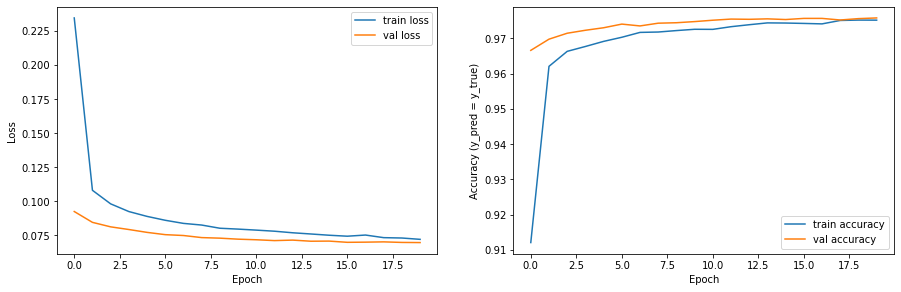

In [39]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [40]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

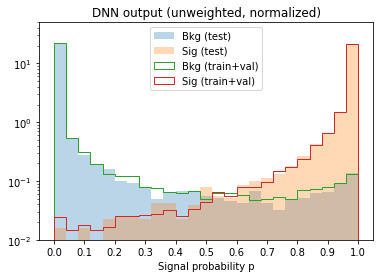

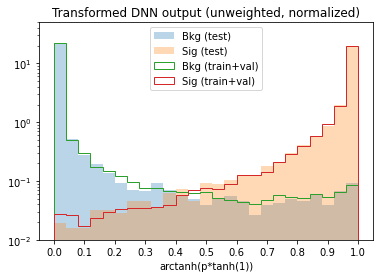

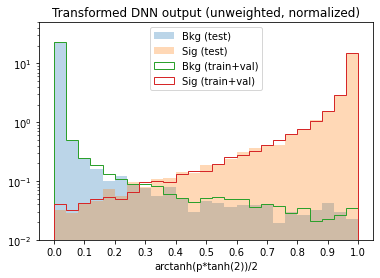

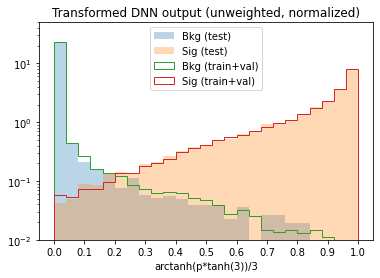

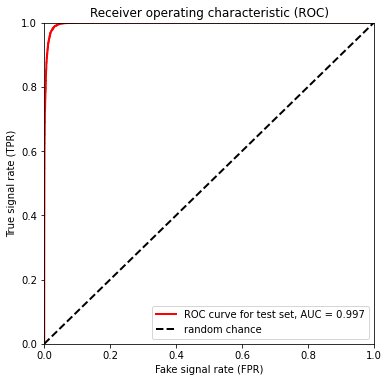

Test loss, test accuracy: [0.06298360326759272, 0.9784172773361206]


In [41]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 25, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 25, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 25, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 25, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 25, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 32, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 25, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 25, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 25, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 25, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 25, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 25, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 25, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 25, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 25, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 25, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 25, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 25, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Save trained model

In [42]:
joblib.dump(scaler, 'trained_models/em1b_scaler.gz')
model.save('trained_models/em1b_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models/em1b_scaler.gz')
savedmodel = keras.models.load_model('trained_models/em1b_model')
savedmodel.summary()

# Write model prediction to root files

## Load all root files one by one

In [43]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/em18_raw/'
outfolder18 = 'root_outputs/em18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('emu_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/em17_raw/'
outfolder17 = 'root_outputs/em17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('emu_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/em16_raw/'
outfolder16 = 'root_outputs/em16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('emu_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [44]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

root_raw/em18_raw/DY.root
root_raw/em18_raw/DY1.root
root_raw/em18_raw/DY2.root
root_raw/em18_raw/DY3.root
root_raw/em18_raw/DY4.root
root_raw/em18_raw/GGHTT.root
root_raw/em18_raw/GGHWW.root
root_raw/em18_raw/GGZHLLTT.root
root_raw/em18_raw/GGZHNNTT.root
root_raw/em18_raw/GGZHQQTT.root
root_raw/em18_raw/GGZHWW.root
root_raw/em18_raw/ST_tW_antitop.root
root_raw/em18_raw/ST_tW_top.root
root_raw/em18_raw/ST_t_antitop.root
root_raw/em18_raw/ST_t_top.root
root_raw/em18_raw/TTTo2L2Nu.root
root_raw/em18_raw/TTToHadronic.root
root_raw/em18_raw/TTToSemiLeptonic.root
root_raw/em18_raw/VBFHTT.root
root_raw/em18_raw/VBFHWW.root
root_raw/em18_raw/VV2L2Nu.root
root_raw/em18_raw/WZ2L2Q.root
root_raw/em18_raw/WZ3LNu.root
root_raw/em18_raw/WminusHTT.root
root_raw/em18_raw/WminusHWW.root
root_raw/em18_raw/WplusHTT.root
root_raw/em18_raw/WplusHWW.root
root_raw/em18_raw/ZHTT.root
root_raw/em18_raw/ZHWW.root
root_raw/em18_raw/ZZ2L2Q.root
root_raw/em18_raw/ZZ4L.root
root_raw/em18_raw/data_obs.root
root_raw

In [46]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

root_raw/em17_raw/DY.root
root_raw/em17_raw/DY1.root
root_raw/em17_raw/DY2.root
root_raw/em17_raw/DY3.root
root_raw/em17_raw/DY4.root
root_raw/em17_raw/GGHTT.root
root_raw/em17_raw/GGHWW.root
root_raw/em17_raw/GGZHLLTT.root
root_raw/em17_raw/GGZHNNTT.root
root_raw/em17_raw/GGZHQQTT.root
root_raw/em17_raw/GGZHWW.root
root_raw/em17_raw/ST_tW_antitop.root
root_raw/em17_raw/ST_tW_top.root
root_raw/em17_raw/ST_t_antitop.root
root_raw/em17_raw/ST_t_top.root
root_raw/em17_raw/TTTo2L2Nu.root
root_raw/em17_raw/TTToHadronic.root
root_raw/em17_raw/TTToSemiLeptonic.root
root_raw/em17_raw/VBFHTT.root
root_raw/em17_raw/VBFHWW.root
root_raw/em17_raw/VV2L2Nu.root
root_raw/em17_raw/WZ2L2Q.root
root_raw/em17_raw/WZ3L1Nu.root
root_raw/em17_raw/WminusHTT.root
root_raw/em17_raw/WminusHWW.root
root_raw/em17_raw/WplusHTT.root
root_raw/em17_raw/WplusHWW.root
root_raw/em17_raw/ZHTT.root
root_raw/em17_raw/ZHWW.root
root_raw/em17_raw/ZZ2L2Q.root
root_raw/em17_raw/ZZ4L.root
root_raw/em17_raw/data_obs.root
root_ra

In [48]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

root_raw/em16_raw/DY.root
root_raw/em16_raw/DY1.root
root_raw/em16_raw/DY2.root
root_raw/em16_raw/DY3.root
root_raw/em16_raw/DY4.root
root_raw/em16_raw/GGHTT.root
root_raw/em16_raw/GGHWW.root
root_raw/em16_raw/GGZHLLTT.root
root_raw/em16_raw/GGZHNNTT.root
root_raw/em16_raw/GGZHQQTT.root
root_raw/em16_raw/GGZHWW.root
root_raw/em16_raw/ST_tW_antitop.root
root_raw/em16_raw/ST_tW_top.root
root_raw/em16_raw/ST_t_antitop.root
root_raw/em16_raw/ST_t_top.root
root_raw/em16_raw/TT.root
root_raw/em16_raw/VBFHTT.root
root_raw/em16_raw/VBFHWW.root
root_raw/em16_raw/VV2L2Nu.root
root_raw/em16_raw/WZ2L2Q.root
root_raw/em16_raw/WZ3L1Nu.root
root_raw/em16_raw/WminusHTT.root
root_raw/em16_raw/WminusHWW.root
root_raw/em16_raw/WplusHTT.root
root_raw/em16_raw/WplusHWW.root
root_raw/em16_raw/ZHTT.root
root_raw/em16_raw/ZHWW.root
root_raw/em16_raw/ZZ2L2Q.root
root_raw/em16_raw/ZZ4L.root
root_raw/em16_raw/data_obs.root
root_raw/em16_raw/embedded.root
root_raw/em16_raw/ggH_bbtt15.root
root_raw/em16_raw/ggH_bb

## Feed to NN and write outputs to root files

In [45]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'emu_tree_dnn', mode = 'update')
    print(outpaths18[i])

root_outputs/em18_outputs/DY.root
root_outputs/em18_outputs/DY1.root
root_outputs/em18_outputs/DY2.root
root_outputs/em18_outputs/DY3.root
root_outputs/em18_outputs/DY4.root
root_outputs/em18_outputs/GGHTT.root
root_outputs/em18_outputs/GGHWW.root
root_outputs/em18_outputs/GGZHLLTT.root
root_outputs/em18_outputs/GGZHNNTT.root
root_outputs/em18_outputs/GGZHQQTT.root
root_outputs/em18_outputs/GGZHWW.root
root_outputs/em18_outputs/ST_tW_antitop.root
root_outputs/em18_outputs/ST_tW_top.root
root_outputs/em18_outputs/ST_t_antitop.root
root_outputs/em18_outputs/ST_t_top.root
root_outputs/em18_outputs/TTTo2L2Nu.root
root_outputs/em18_outputs/TTToHadronic.root
root_outputs/em18_outputs/TTToSemiLeptonic.root
root_outputs/em18_outputs/VBFHTT.root
root_outputs/em18_outputs/VBFHWW.root
root_outputs/em18_outputs/VV2L2Nu.root
root_outputs/em18_outputs/WZ2L2Q.root
root_outputs/em18_outputs/WZ3LNu.root
root_outputs/em18_outputs/WminusHTT.root
root_outputs/em18_outputs/WminusHWW.root
root_outputs/em18_

In [47]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'emu_tree_dnn', mode = 'update')
    print(outpaths17[i])

root_outputs/em17_outputs/DY.root
root_outputs/em17_outputs/DY1.root
root_outputs/em17_outputs/DY2.root
root_outputs/em17_outputs/DY3.root
root_outputs/em17_outputs/DY4.root
root_outputs/em17_outputs/GGHTT.root
root_outputs/em17_outputs/GGHWW.root
root_outputs/em17_outputs/GGZHLLTT.root
root_outputs/em17_outputs/GGZHNNTT.root
root_outputs/em17_outputs/GGZHQQTT.root
root_outputs/em17_outputs/GGZHWW.root
root_outputs/em17_outputs/ST_tW_antitop.root
root_outputs/em17_outputs/ST_tW_top.root
root_outputs/em17_outputs/ST_t_antitop.root
root_outputs/em17_outputs/ST_t_top.root
root_outputs/em17_outputs/TTTo2L2Nu.root
root_outputs/em17_outputs/TTToHadronic.root
root_outputs/em17_outputs/TTToSemiLeptonic.root
root_outputs/em17_outputs/VBFHTT.root
root_outputs/em17_outputs/VBFHWW.root
root_outputs/em17_outputs/VV2L2Nu.root
root_outputs/em17_outputs/WZ2L2Q.root
root_outputs/em17_outputs/WZ3L1Nu.root
root_outputs/em17_outputs/WminusHTT.root
root_outputs/em17_outputs/WminusHWW.root
root_outputs/em17

In [49]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'emu_tree_dnn', mode = 'update')
    print(outpaths16[i])

root_outputs/em16_outputs/DY.root
root_outputs/em16_outputs/DY1.root
root_outputs/em16_outputs/DY2.root
root_outputs/em16_outputs/DY3.root
root_outputs/em16_outputs/DY4.root
root_outputs/em16_outputs/GGHTT.root
root_outputs/em16_outputs/GGHWW.root
root_outputs/em16_outputs/GGZHLLTT.root
root_outputs/em16_outputs/GGZHNNTT.root
root_outputs/em16_outputs/GGZHQQTT.root
root_outputs/em16_outputs/GGZHWW.root
root_outputs/em16_outputs/ST_tW_antitop.root
root_outputs/em16_outputs/ST_tW_top.root
root_outputs/em16_outputs/ST_t_antitop.root
root_outputs/em16_outputs/ST_t_top.root
root_outputs/em16_outputs/TT.root
root_outputs/em16_outputs/VBFHTT.root
root_outputs/em16_outputs/VBFHWW.root
root_outputs/em16_outputs/VV2L2Nu.root
root_outputs/em16_outputs/WZ2L2Q.root
root_outputs/em16_outputs/WZ3L1Nu.root
root_outputs/em16_outputs/WminusHTT.root
root_outputs/em16_outputs/WminusHWW.root
root_outputs/em16_outputs/WplusHTT.root
root_outputs/em16_outputs/WplusHWW.root
root_outputs/em16_outputs/ZHTT.root
